# Import data

A bunch of stuff to import data, covariances, and generate $C_\ell$'s. Takes a while to "precompile"

In [1]:
using Pkg

Pkg.activate("Anomaly_detection_CMB")

using Anomaly_detection_CMB

  Activating project at `~/Dropbox/Academic_2024/anomaly_detection_personal/Anomaly_detection_CMB`


In [2]:
using NPZ

# Define the path where the Planck data is located
planckpath = "planck_data/"

# Load the necessary data files using npzread from the NPZ library
data = npzread(joinpath(planckpath, "data.npy"))
cov = npzread(joinpath(planckpath, "cov.npy"))
blmin_TT = npzread(joinpath(planckpath, "blmin_TT.npy"))
blmax_TT = npzread(joinpath(planckpath, "blmax_TT.npy"))
bin_w_TT = npzread(joinpath(planckpath, "bin_w_TT.npy"))
bin_w = npzread(joinpath(planckpath, "bin_w.npy"))

# Notes:
# - planckpath: This path holds the location of all necessary Planck data files.
# - npzread: A function from the NPZ library to load .npy files.
# - The variables data, cov, blmin_TT, etc., are now populated with the contents of their respective .npy files.


7437-element Vector{Float64}:
 0.17580340264650285
 0.18752362948960302
 0.1996219281663516
 0.2120982986767486
 0.22495274102079396
 0.17897727272727273
 0.18920454545454546
 0.19971590909090908
 0.21051136363636364
 0.2215909090909091
 0.18141592920353983
 0.19048672566371683
 0.1997787610619469
 ⋮
 0.03042428508730042
 0.03044865375777483
 0.030473032183521646
 0.030497420364540874
 0.030521818300832504
 0.030546225992396547
 0.030570643439232995
 0.03059507064134185
 0.030619507598723113
 0.030643954311376783
 0.030668410779302862
 0.03069287700250135

In [3]:
# Setting up constants for the binning process
plmin_TT = 30
plmin = 30
nbintt = 215
nbinte = 199
nbinee = 199
ellmin = 2

# Compute the mean value of blmin_TT and blmax_TT to get the lmean for further calculations
lmean = (blmin_TT .+ blmax_TT) .// 2
lmean = lmean[(lmean .>= 30) .& (lmean .< 2508)]

# Notes:
# - lmean represents the average multipole moments used for binning.
# - We are only considering values of lmean between 30 and 2508 for the next steps.
# - The constants like plmin and nbintt are used to define binning ranges for the power spectrum.


215-element Vector{Rational{Int64}}:
   32
   37
   42
   47
   52
   57
   62
   67
   74
   83
   92
  101
  110
    ⋮
 2297
 2330
 2363
 2396
 2429
 2462
 2481
 2486
 2491
 2496
 2501
 2506

In [4]:
using SimpleChains

# Define the architecture of the neural network emulator (mlpd)
mlpd = SimpleChain(
    static(6),  # Input size (6 cosmological parameters)
    TurboDense(tanh, 64),  # Dense layers with 64 neurons and tanh activation
    TurboDense(tanh, 64),
    TurboDense(tanh, 64),
    TurboDense(tanh, 64),
    TurboDense(tanh, 64),
    TurboDense(identity, 4999)  # Output layer with 4999 values (ClTT output size)
)

# Notes:
# - mlpd defines a multi-layer perceptron (MLP) neural network with 6 inputs (cosmological parameters) and 4999 outputs (ClTT values).
# - TurboDense layers apply dense transformations with a tanh activation function for non-linearity.
# - The final layer has an identity activation function, meaning it directly outputs the predicted ClTT values.


[ Info: Precompiling SimpleChains [de6bee2f-e2f4-4ec7-b6ed-219cc6f6e9e5]


SimpleChain with the following layers:
TurboDense static(64) with bias.
Activation layer applying: tanh
TurboDense static(64) with bias.
Activation layer applying: tanh
TurboDense static(64) with bias.
Activation layer applying: tanh
TurboDense static(64) with bias.
Activation layer applying: tanh
TurboDense static(64) with bias.
Activation layer applying: tanh
TurboDense static(4999) with bias.

In [5]:
using NPZ

# Load additional required files for the emulator
ℓ = npzread("chains_weights/weights/weights_cosmopowerspace_10000/l.npy")
weights_TT = npzread("chains_weights/weights/weights_cosmopowerspace_10000/weights_TT_lcdm.npy")
inMinMax_TT = npzread("chains_weights/weights/weights_cosmopowerspace_10000/inMinMax_lcdm.npy")
outMinMaxCℓTT = npzread("chains_weights/weights/weights_cosmopowerspace_10000/outMinMaxCℓTT_lcdm.npy")

# Notes:
# - ℓ is the multipole grid (range of ell values for ClTT computation).
# - weights_TT are the trained weights for the ClTT emulator using cosmological parameters.
# - inMinMax_TT and outMinMaxCℓTT are the normalization factors used to scale the input and output of the emulator for better numerical stability.


4999×2 Matrix{Float64}:
 465.272     2419.36
 472.564     2044.2
 476.975     1780.64
 480.088     1599.87
 480.848     1474.17
 482.798     1385.77
 484.347     1322.19
 488.196     1284.46
 493.224     1258.24
 499.518     1239.69
 507.461     1228.73
 516.289     1222.73
 525.403     1220.22
   ⋮         
   0.135121     7.40164
   0.134893     7.39753
   0.134667     7.39346
   0.134444     7.38942
   0.134223     7.38542
   0.134006     7.38145
   0.13379      7.37751
   0.133575     7.37359
   0.133362     7.36968
   0.133149     7.36579
   0.132936     7.36189
   0.132722     7.35799

In [6]:
using Capse

# Create a trained emulator instance for ClTT using the pre-defined neural network architecture
trained_emu_TT = Capse.SimpleChainsEmulator(Architecture = mlpd, Weights = weights_TT)

# Include the postprocessing function defined in the provided script
include("chains_weights/weights/weights_cosmopowerspace_10000/postprocessing.jl")

# Create the ClTT emulator instance with the trained neural network and relevant grid information
ClTT_emu = Capse.CℓEmulator(
    TrainedEmulator = trained_emu_TT,
    ℓgrid = ℓ,
    InMinMax = inMinMax_TT,
    OutMinMax = outMinMaxCℓTT,
    Postprocessing = postprocessing  # Postprocessing function is applied to the emulator's output
)

# Notes:
# - trained_emu_TT is the neural network-based emulator, trained on cosmological parameters to predict ClTT values.
# - ClTT_emu combines the neural network emulator, the multipole grid, and the scaling factors to create a full ClTT emulator.
# - The postprocessing step modifies the raw outputs from the neural network, applying any necessary transformations (like exponential scaling).


Precompiling Capse
  ✓ WeightInitializers
  ✓ WeightInitializers → WeightInitializersGPUArraysExt
  ✓ WeightInitializers → WeightInitializersChainRulesCoreExt
  ✓ NNlib → NNlibForwardDiffExt
  ✓ Octavian → ForwardDiffExt
  ✓ OneHotArrays
  ✓ Zygote
  ✓ MLDataDevices → MLDataDevicesZygoteExt
  ✓ LuxDeviceUtils → LuxDeviceUtilsZygoteExt
  ✓ Flux
  ✓ LuxLib
  ✓ Lux
  ✓ Lux → LuxMLUtilsExt
  ✓ Lux → LuxSimpleChainsExt
  ✓ Lux → LuxZygoteExt
  ✓ Lux → LuxFluxExt
  ✓ AbstractCosmologicalEmulators
  ✓ Capse
  18 dependencies successfully precompiled in 55 seconds. 193 already precompiled.
[ Info: Precompiling Capse [994f66c3-d2c7-4ba6-88fb-4a10f50800ba]
┌ Warning: Module ForwardDiff with build ID fafbfcfd-c6ac-56df-0000-a21133ea93a4 is missing from the cache.
│ This may mean ForwardDiff [f6369f11-7733-5829-9624-2563aa707210] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1948
[ Info: Skipping precompilation since __precompile__(false). Importing Cap

Capse.CℓEmulator(AbstractCosmologicalEmulators.SimpleChainsEmulator(SimpleChain with the following layers:
TurboDense static(64) with bias.
Activation layer applying: tanh
TurboDense static(64) with bias.
Activation layer applying: tanh
TurboDense static(64) with bias.
Activation layer applying: tanh
TurboDense static(64) with bias.
Activation layer applying: tanh
TurboDense static(64) with bias.
Activation layer applying: tanh
TurboDense static(4999) with bias., Float32[-0.09438385, -0.0978219, -0.0076226187, 0.08652166, 0.20455036, -0.076574214, 0.012764122, -0.15286958, -0.047126386, -0.13246603  …  0.034119494, 0.04157617, 0.041488867, 0.0264629, 0.030019198, 0.035513565, 0.026862752, 0.035884954, 0.035462964, 0.029407568], Dict{Any, Any}()), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9  …  10041, 10042, 10043, 10044, 10045, 10046, 10047, 10048, 10049, 10050], [2.5000309455846046 3.4999169546418525; 0.8800147176695812 1.0499864337699982; … ; 0.08000258027359056 0.19998849066480973; 0.020001101523

In [7]:
# Test input for the ClTT emulator (example cosmological parameters)
input_test = [3.1, 0.96, 67, 0.02, 0.12, 0.05]

# Get the ClTT predictions from the emulator based on the test input
Cltt = Capse.get_Cℓ(input_test, ClTT_emu)

# Notes:
# - input_test represents a set of cosmological parameters (like ln10As, ns, H0, etc.).
# - Capse.get_Cℓ takes the cosmological parameters as input and uses the ClTT emulator to predict the corresponding power spectrum (ClTT).
# - The result is stored in Cltt, which is a vector of 4999 values representing the ClTT power spectrum.


4999-element Vector{Float64}:
 1103.6865388945985
 1046.2860194958514
  991.3144370636879
  949.9717875826143
  921.6190506776312
  903.2707583810568
  891.8567333993673
  886.8713430164197
  885.3601596861386
  886.7158643538311
  891.4271849030455
  898.0242987519447
  905.5907794332973
    ⋮
    1.1214451315561942
    1.1206444475654957
    1.1197341517209012
    1.118982140042143
    1.1181036990897764
    1.117543628056821
    1.1166022704886769
    1.1157828881774186
    1.1150948252420898
    1.114408699313649
    1.1134977577593073
    1.1128451643043376

In [8]:
# If the binTT function hasn't been defined yet, define it now
using LinearAlgebra

# Function to bin the ClTT data using the weights and ranges defined earlier
function binTT(Cltt)
    Cltt_bin = zeros(nbintt)  # Initialize the array to store binned ClTT values
    for i in 1:nbintt
        Cltt_bin[i] = dot(
            Cltt[blmin_TT[i] + plmin_TT - ellmin + 1 : blmax_TT[i] + plmin_TT + 1 - ellmin],
            bin_w_TT[blmin_TT[i] + 1 : blmax_TT[i] + 1]
        )
    end
    return Cltt_bin
end

# Apply the binning function to the ClTT predictions
Cltt_binned = binTT(Cltt)

# Notes:
# - binTT applies the binning process to the predicted ClTT values using predefined weights and ranges.
# - Cltt_binned now contains the binned power spectrum data for comparison with observational data.


215-element Vector{Float64}:
 1165.3295997228417
 1254.7615407426679
 1349.1004410425858
 1447.9690395518535
 1551.5212833340715
 1659.8341757738674
 1773.3446878955424
 1892.1699442332817
 2017.4585615794413
 2148.514322989189
 2283.951032671907
 2427.3807717764785
 2576.660560417095
    ⋮
  182.41917481195665
  160.7091469791394
  142.1289437720998
  128.7321473685576
  120.51295910108618
  115.8091362431746
  112.27313122057006
  107.89969553639982
  101.70905640907486
   93.89168427345254
   85.45156194968116
   77.62433178096208

[ Info: Precompiling SpecialFunctionsExt [997ecda8-951a-5f50-90ea-61382e97704b]
┌ Warning: Module SpecialFunctions with build ID fafbfcfd-a5b0-e5c6-0000-a211432df6e2 is missing from the cache.
│ This may mean SpecialFunctions [276daf66-3868-5448-9aa4-cd146d93841b] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1948
[ Info: Skipping precompilation since __precompile__(false). Importing SpecialFunctionsExt [997ecda8-951a-5f50-90ea-61382e97704b].


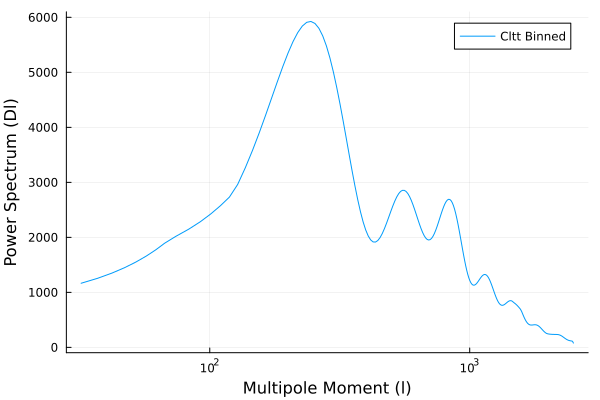

In [9]:
using Plots

# Plot the binned power spectrum on a log-log scale
plot(lmean, Cltt_binned, label="Cltt Binned", xscale=:log10)

xlabel!("Multipole Moment (l)")
ylabel!("Power Spectrum (Dl)")

# Notes:
# - This plots the binned ClTT power spectrum against the mean multipole moment (lmean).
# - Both axes are on a logarithmic scale to capture the wide range of values.


In [10]:
# Symmetrize the covariance matrix and ensure it is positive definite
covTT = (cov[1:215, 1:215] + cov[1:215, 1:215]') / 2

# Notes:
# - This step symmetrizes the covariance matrix by averaging it with its transpose.
# - This ensures that any small numerical asymmetries are corrected.


215×215 Matrix{Float64}:
  0.480394     -0.0222793    -0.00103739   …   5.69365e-8    5.48292e-8
 -0.0222793     0.269082     -0.0128421        2.31364e-8    3.42469e-8
 -0.00103739   -0.0128421     0.166714         2.10059e-8    1.56695e-8
  0.000371933  -0.000548957  -0.00785384       4.53441e-9   -1.08232e-8
  2.5468e-5    -0.000187197  -0.000473712      2.52432e-8    9.86261e-9
  0.000173131   0.000409475  -0.000310591  …   8.06046e-9   -2.71583e-9
  0.000389014  -0.000142217  -0.000117338      8.27675e-9    5.18942e-9
  2.65702e-5    2.69531e-6    0.000195302      7.26684e-9    8.1608e-11
  0.000373775   0.000191381   5.59668e-5       4.71786e-9    7.95024e-9
 -0.000118541   0.000272119   0.000117014      1.03746e-9   -4.46673e-9
  0.000197237   3.00468e-5    0.0002229    …   1.33623e-9   -2.6675e-9
  8.1791e-5     5.05292e-5   -6.85366e-5       5.93793e-9    7.51844e-9
 -2.63353e-5    0.000120068  -2.75213e-6      -1.80816e-10  -3.03251e-9
  ⋮                                     

In [11]:
using LinearAlgebra

# Check if the covariance matrix is symmetric and positive definite
issymmetric(covTT) && all(eigvals(covTT) .> 0)

# Add a small value to the diagonal to make it positive definite if necessary
covTT += 1e-10I

# Notes:
# - This code checks that the covariance matrix is symmetric and positive definite (a necessary property for covariance matrices).
# - Adding a small value to the diagonal (1e-10) ensures numerical stability when performing further calculations.


215×215 Matrix{Float64}:
  0.480394     -0.0222793    -0.00103739   …   5.69365e-8    5.48292e-8
 -0.0222793     0.269082     -0.0128421        2.31364e-8    3.42469e-8
 -0.00103739   -0.0128421     0.166714         2.10059e-8    1.56695e-8
  0.000371933  -0.000548957  -0.00785384       4.53441e-9   -1.08232e-8
  2.5468e-5    -0.000187197  -0.000473712      2.52432e-8    9.86261e-9
  0.000173131   0.000409475  -0.000310591  …   8.06046e-9   -2.71583e-9
  0.000389014  -0.000142217  -0.000117338      8.27675e-9    5.18942e-9
  2.65702e-5    2.69531e-6    0.000195302      7.26684e-9    8.1608e-11
  0.000373775   0.000191381   5.59668e-5       4.71786e-9    7.95024e-9
 -0.000118541   0.000272119   0.000117014      1.03746e-9   -4.46673e-9
  0.000197237   3.00468e-5    0.0002229    …   1.33623e-9   -2.6675e-9
  8.1791e-5     5.05292e-5   -6.85366e-5       5.93793e-9    7.51844e-9
 -2.63353e-5    0.000120068  -2.75213e-6      -1.80816e-10  -3.03251e-9
  ⋮                                     

In [12]:
using Random, Distributions

# Generate random noise using a multivariate normal distribution with the covariance matrix
rng = MersenneTwister(1234)  # Set a seed for reproducibility
randerr = rand(MvNormal(zeros(215), covTT))

# Notes:
# - A random noise vector is generated using a multivariate normal distribution with zero mean and the covariance matrix (covTT).
# - Setting a seed with MersenneTwister ensures reproducibility of the random values.


Precompiling Distributions
  ✓ HypergeometricFunctions
  ✓ StatsFuns
  ✓ StatsFuns → StatsFunsInverseFunctionsExt
  ✓ StatsFuns → StatsFunsChainRulesCoreExt
  ✓ Distributions
  5 dependencies successfully precompiled in 7 seconds. 39 already precompiled.
[ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
┌ Warning: Module SpecialFunctions with build ID fafbfcfd-a5b0-e5c6-0000-a211432df6e2 is missing from the cache.
│ This may mean SpecialFunctions [276daf66-3868-5448-9aa4-cd146d93841b] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1948
[ Info: Skipping precompilation since __precompile__(false). Importing Distributions [31c24e10-a181-5473-b8eb-7969acd0382f].
[ Info: Precompiling StatsFuns [4c63d2b9-4356-54db-8cca-17b64c39e42c]
┌ Warning: Module SpecialFunctions with build ID fafbfcfd-a5b0-e5c6-0000-a211432df6e2 is missing from the cache.
│ This may mean SpecialFunctions [276daf66-3868-5448-9aa4-cd146d93841b] does not s

215-element Vector{Float64}:
  0.9506042898375994
 -0.6278076754175254
 -0.8770826513948939
 -0.23891035462848786
  0.302522360318719
 -0.20264228081863234
  0.07781869234154207
  0.177633699338105
 -0.10425990851878097
  0.02244559964702579
 -0.1486612569124281
  0.2788674996394442
 -0.19392460507155873
  ⋮
 -1.9202129230838226e-5
 -1.585289607921911e-5
 -1.7498837318883609e-6
 -4.480668773053212e-6
  1.998709023080714e-6
 -6.008900280430406e-7
 -2.935895374665133e-5
 -6.126761985516122e-6
 -9.638549355684232e-6
 -9.71490103953411e-6
  1.088503785617767e-5
  7.470119481852505e-6

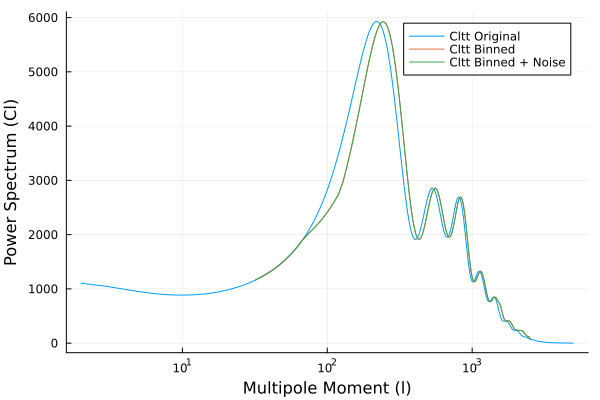

In [13]:
using Plots

# Plot the original Cltt, binned Cltt, and the binned Cltt with added noise
l = 2:5000
plot(l, Cltt, label="Cltt Original", xscale=:log10)
plot!(lmean, Cltt_binned, label="Cltt Binned")
plot!(lmean, Cltt_binned + randerr, label="Cltt Binned + Noise")

xlabel!("Multipole Moment (l)")
ylabel!("Power Spectrum (Cl)")

# Notes:
# - This plot shows the original ClTT, the binned ClTT, and the binned ClTT with added noise for comparison.
# - Both axes use a log scale to represent the wide range of values.


In [14]:
using Random, Distributions

# Generate multiple samples of noisy ClTT data for statistical analysis
rng = MersenneTwister(1234)  # Seed for reproducibility
n_samples = Int(1e4)  # Define the number of samples (10,000)
randerr = [rand(MvNormal(zeros(215), covTT)) for _ in 1:n_samples]

# Generate perturbed ClTT data by adding the random noise to the binned ClTT
randClTT = [Cltt_binned ./ (lmean .* (lmean .+ 1) ./ (2 * π)) .+ re for re in randerr]

# Notes:
# - This section generates 10,000 samples of noisy ClTT data by repeatedly adding random noise to the binned ClTT.
# - These samples will be used for statistical analysis (e.g., p-value calculation).


10000-element Vector{Vector{Float64}}:
 [6.145486571950348, 5.197168578816623, 4.439930296502599, 3.3384366287670377, 3.8177825258617535, 3.3102289663833977, 2.710558472428504, 2.590538600584221, 2.3339199363323866, 1.9783625563187557  …  0.00017988567851867646, 0.0001891473432060347, 0.00015399507425182317, 0.00015275454193053314, 0.00015705779295756753, 0.00013112451404106136, 0.00015540103216362842, 0.0001243280961355555, 0.00012685614921204323, 0.00011021959032351893]
 [7.527018862778082, 6.443727517417958, 4.569157545102528, 4.124152159926349, 3.6654312316336894, 3.312664535073465, 2.6534820016610916, 2.72316119272146, 2.1806018110602996, 2.0696571121278833  …  0.00016291865703225474, 0.0001552401850548557, 0.0001309770900905252, 0.0001161711884880446, 0.00012137281890602531, 0.00010925488641284268, 0.00010218968008274246, 8.965645175373304e-5, 9.432238823913878e-5, 8.761741283086601e-5]
 [5.973840749787957, 5.6017986009649885, 4.6558597635941235, 4.103807731386556, 3.642919485532

In [15]:
# Convert the list of noisy ClTT samples into a matrix
randClTT_matrix = hcat(randClTT...)

# Notes:
# - The list of noisy ClTT vectors is concatenated into a single matrix for easier manipulation and plotting.
# - Each column in randClTT_matrix represents one sample of perturbed ClTT data.


215×10000 Matrix{Float64}:
 6.14549      7.52702      5.97384      …  7.47687      6.0267
 5.19717      6.44373      5.6018          6.15128      5.70956
 4.43993      4.56916      4.65586         5.10386      4.26179
 3.33844      4.12415      4.10381         4.57244      4.29243
 3.81778      3.66543      3.64292         3.41932      3.41128
 3.31023      3.31266      2.8055       …  3.32022      2.78952
 2.71056      2.65348      3.1368          2.97704      3.10311
 2.59054      2.72316      2.4725          2.43773      2.68039
 2.33392      2.1806       2.41862         2.1106       2.24659
 1.97836      2.06966      1.92455         2.07961      1.83461
 1.48817      1.65238      1.70596      …  1.50219      1.45052
 1.41799      1.46474      1.46217         1.5245       1.50797
 1.12046      1.37463      1.45408         1.42312      1.38384
 ⋮                                      ⋱               
 0.000228422  0.000250703  0.000242929     0.000206416  0.000213063
 0.00020676   0.0

In [16]:
using Plots

# Supongamos que `lmean` está definido y tiene la longitud adecuada
# lmean debería tener la misma longitud que las columnas de randClTT_matrix

# Convertir Dℓ a Cℓ
normed_Cltt_matrix = randClTT_matrix .* (lmean .* (lmean .+ 1) ./ (2 * π))

215×10000 Matrix{Float64}:
 1032.86   1265.05    1004.01    …  1258.73    1256.62    1012.89
 1162.98   1441.92    1253.52       1240.55    1376.48    1277.64
 1276.19   1313.33    1338.25       1542.07    1467.02    1224.98
 1198.68   1480.79    1473.49       1243.72    1641.75    1541.21
 1674.6    1607.77    1597.9        1661.5     1499.82    1496.3
 1741.73   1743.01    1476.16    …  1610.07    1746.99    1467.75
 1685.04   1649.56    1950.02       1675.79    1850.7     1929.07
 1878.43   1974.59    1792.83       1915.95    1767.62    1943.57
 2061.57   1926.15    2136.39       2272.99    1864.31    1984.44
 2195.25   2296.55    2135.54       1929.54    2307.59    2035.73
 2026.49   2250.1     2323.06    …  2270.24    2045.57    1975.21
 2324.96   2401.61    2397.4        2590.52    2499.59    2472.48
 2177.38   2671.29    2825.68       2591.47    2765.52    2689.19
    ⋮                            ⋱                        
  191.898   210.616    204.085       196.048    173.41   

In [17]:
normed_Cltt_matrix[:,1]

215-element Vector{Float64}:
 1032.8573013060875
 1162.980027577168
 1276.1861577313666
 1198.6775284014668
 1674.5978555259342
 1741.730734944043
 1685.0436324403518
 1878.4252393090167
 2061.5746652965163
 2195.2470074204875
 2026.4905331672237
 2324.9625512460884
 2177.3767597025308
    ⋮
  191.8975873077132
  178.72520643931318
  159.92925498578964
  172.89213005188992
  144.66409336686766
  147.4235022610859
  153.92464595884167
  129.02709900885083
  153.53090015151247
  123.32540156289485
  126.33760880800494
  110.20830543371866

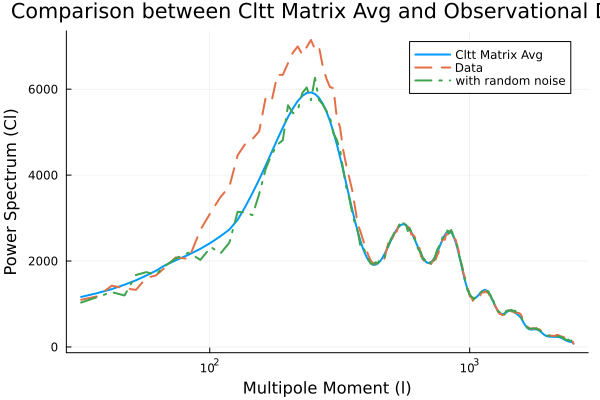

In [18]:

using Plots

# Take the average of the columns of Cltt_matrix for comparison
Cltt_matrix_avg = mean(randClTT_matrix, dims=2)

# Plot Cltt_matrix_avg and data on the same scale
plot(lmean, Cltt_matrix_avg .* (lmean .* (lmean .+ 1) ./ (2 * π)), label="Cltt Matrix Avg", xscale=:log10, lw=2)
plot!(lmean, data[1:length(lmean)] .* (lmean .* (lmean .+ 1) ./ (2 * π)), label="Data", lw=2, linestyle=:dash)
plot!(lmean, normed_Cltt_matrix[:,1], label="with random noise", lw=2, linestyle=:dashdot)

# Set labels and title
xlabel!("Multipole Moment (l)")
ylabel!("Power Spectrum (Cl)")
title!("Comparison between Cltt Matrix Avg and Observational Data")


In [19]:
# Verify the dimensions of Cltt_matrix_avg, covTT, and data
println("Dimensions of Cltt_matrix_avg: ", size(Cltt_matrix_avg))
println("Dimensions of covTT: ", size(covTT))
println("Dimensions of data: ", size(data))

# Verify that lmean has the expected length
println("Dimensions of lmean: ", size(lmean))


Dimensions of Cltt_matrix_avg: (215, 1)
Dimensions of covTT: (215, 215)
Dimensions of data: (613,)
Dimensions of lmean: (215,)


In [20]:
using LinearAlgebra

# Assume covTT is the full covariance matrix (215, 215), and that X_train has 215 data points

# Ensure that X_train, y_train, and covTT have the correct dimensions
X_train = reshape(lmean, 1, :)
n_R = Cltt_matrix_avg[:,1]

# Verify dimensions
println("Dimensions of X_train: ", size(X_train))
println("Dimensions of n_R: ", size(n_R))

# Do not crop the covariance matrix
inv_covTT = inv(covTT)
println("Dimensions of inv_covTT: ", size(inv_covTT))

@assert size(inv_covTT)[1] == size(n_R)[1]
@assert size(n_R)[1] == size(X_train)[2]

Dimensions of X_train: (1, 215)
Dimensions of n_R: (215,)
Dimensions of inv_covTT: (215, 215)


# The loss function

We use a Gaussian likelihood
$$
L(D|M) = \frac{1}{\sqrt{2\pi \det C}}\exp\left[-\frac{1}{2}\sum_{i,j}(n(x_i|M) - n_i)C_{ij}^{-1}(n(x_j|M) - n_j)\right]
$$

The models will be either a reference standard model $R$ or a modified model defined in terms of a universal approximant.

A possibility is that we modify the model in the following way:
$$
n(x_i | w) = n(x_i | R) e^{f_w(i)}\,.
$$
Where $n(x_i | R)$ is some observable predicted by the reference model, and $w$ are weights that parametrize the approximant $f(w)$. 

Using this, the likelihood ratio gives
$$
    \ln \frac{L_c(D|w)}{L_c(D|R)} = \frac{1}{2} \sum_{i,j} n(x_i|R)  \left[ 2(e^{f_i(w)} C^{-1}_{ij} - C^{-1}_{ij}) n_j - (e^{f_i(w)} C^{-1}_{ij} e^{f_j(w)} - C^{-1}_{ij}) n(x_j|R)  \right] \, .
$$

We see that this has a maximum for each term at $f_i(w) = \ln \frac{n_i}{n(x_i|R)}$ which makes sense.

However, when we plot this as a function of $f$, we get

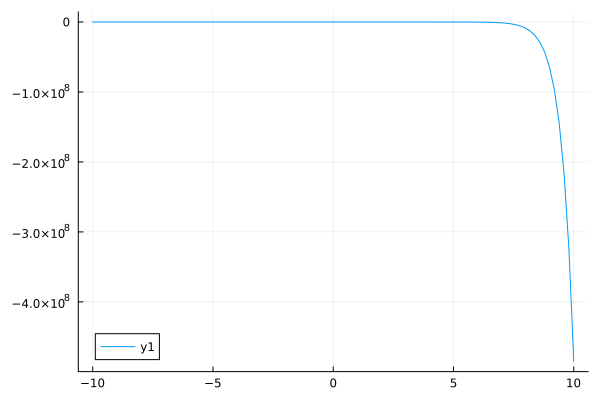

In [21]:
f = range(-10, 10, length=100)
g = 2(exp.(f) .- 1) .- (exp.(2f) .- 1)
plot(f,g)

This behaves badly with gradient descent. Indeed, the exponential part will generate large gradients which don't allow this to converge in a reasonable time. (Indeed this fails the convergence test that we do below.)

Instead, we choose to modify the model as:
$$
n(x_i | w) = n(x_i | R) f_w(i)\,.
$$
Obtaining the log likelihood ratio
$$
    \ln \frac{L_c(D|w)}{L_c(D|R)} = \frac{1}{2} \sum_{i,j} n(x_i|R)  \left[ 2(f_i(w) C^{-1}_{ij} - C^{-1}_{ij}) n_j - (f_i(w) C^{-1}_{ij} f_j(w) - C^{-1}_{ij}) n(x_j|R)  \right] \, .
$$

When performing a similar plot we get

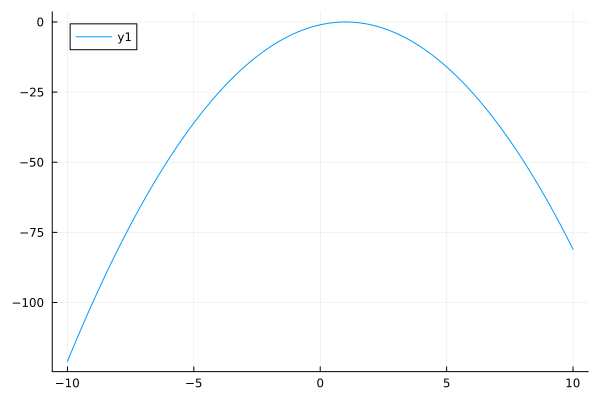

In [22]:
f = range(-10, 10, length=100)
g = 2(f .- 1) .- (f.^2 .- 1)
plot(f,g)

This behaves badly with gradient descent. Indeed, the exponential part will generate large gradients which don't allow this to converge in a reasonable time. (Indeed this fails the convergence test that we do below.)

Instead, we choose to modify the model as:
$$
n(x_i | w) = n(x_i | R) f_w(i)\,.
$$
Obtaining the log likelihood ratio
$$
    \ln \frac{L_c(D|w)}{L_c(D|R)} = \frac{1}{2} \sum_{i,j} n(x_i|R)  \left[ 2(f_i(w) C^{-1}_{ij} - C^{-1}_{ij}) n_j - (f_i(w) C^{-1}_{ij} f_j(w) - C^{-1}_{ij}) n(x_j|R)  \right] \, .
$$

When performing a similar plot we get

We will take minus this log likelihood ratio as a loss to get the best fit model trhough gradient descent.

We also test that in the trivial case $f=1$ the loss gives zero, just to ward against some typos.

In [34]:
using Tullio

function contraction(n_R, f_x_w, inv_cov_matrix, y)
    return @tullio neg_log_like := -n_R[i]*(2*(f_x_w[i] - 1)inv_cov_matrix[i,j]*y[j] - (f_x_w[i]*inv_cov_matrix[i,j]*f_x_w[j] - inv_cov_matrix[i,j])*n_R[j])/2
end

function neg_log_likelihood_ratio(model, X, y, inv_cov_matrix, n_R)
    # Predictions from the trained model
    f_x_w = model(X)[:]
    
    return contraction(n_R, f_x_w, inv_cov_matrix, y)
end

# # Loss function without cropping the data
# function neg_log_likelihood_ratio(model, X, y, inv_cov_matrix, n_R)
#     # Predictions from the trained model
#     f_x_w = Diagonal(model(X)[:])
    
#     return -n_R' * (2((f_x_w .- I) * inv_cov_matrix) * y - 
#              (f_x_w * inv_cov_matrix * f_x_w - inv_cov_matrix)*n_R)/2
# end

# function dummy_model(X)
# return ones(length(X))
# end
# @assert neg_log_likelihood_ratio(dummy_model, X_train, n_R, inv_covTT, n_R) == 0

neg_log_likelihood_ratio (generic function with 1 method)

As a further test, and a first version of the optimization code, we fit the model in the case in which the reference model and the data are *identical*. This should converge towards $f = 1$.

In [35]:
using Flux

# Create the adjusted model
mlpd = Chain(
    Dense(1 => 100, Flux.sigmoid),
    Dense(100 => 1)
)

# Begin optimization
opt = Flux.Adam(0.05)
epochs = 1000
losses = Float64[]

# For this test
y_train = n_R

for epoch in 1:epochs
    gs = gradient(() -> neg_log_likelihood_ratio(mlpd, X_train, y_train, inv_covTT, n_R), Flux.params(mlpd))
    Flux.Optimise.update!(opt, Flux.params(mlpd), gs)
    current_loss = neg_log_likelihood_ratio(mlpd, X_train, y_train, inv_covTT, n_R)
    push!(losses, current_loss)
    println("Epoch $epoch completed, Loss: ", current_loss)
end


Epoch 1 completed, Loss: 1.5331793214493755e6
Epoch 2 completed, Loss: 177265.00258734068
Epoch 3 completed, Loss: 72689.91169858769
Epoch 4 completed, Loss: 464543.92918143043
Epoch 5 completed, Loss: 478624.08046730043
Epoch 6 completed, Loss: 216260.39560599945
Epoch 7 completed, Loss: 14517.335761663962
Epoch 8 completed, Loss: 49153.42977059444
Epoch 9 completed, Loss: 204360.20414392714
Epoch 10 completed, Loss: 262419.7627074845
Epoch 11 completed, Loss: 171594.66003015547
Epoch 12 completed, Loss: 44237.60053721177
Epoch 13 completed, Loss: 1494.0193533442425
Epoch 14 completed, Loss: 57544.018838106225
Epoch 15 completed, Loss: 128618.55778072402
Epoch 16 completed, Loss: 132413.64383044853
Epoch 17 completed, Loss: 71571.4082589659
Epoch 18 completed, Loss: 11348.248663915308
Epoch 19 completed, Loss: 4819.276180649755
Epoch 20 completed, Loss: 43972.4690668448
Epoch 21 completed, Loss: 76718.87127880631
Epoch 22 completed, Loss: 66938.8278615404
Epoch 23 completed, Loss: 283

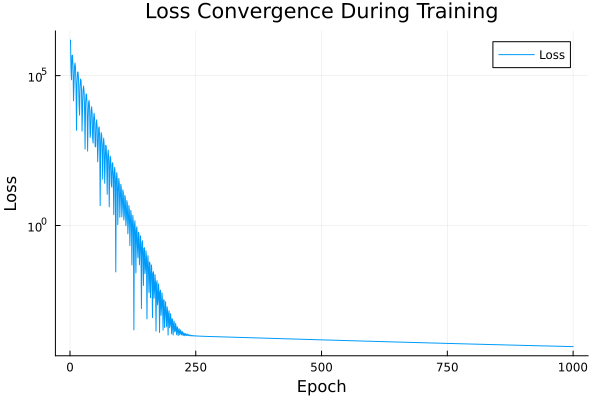

In [36]:
# Plot the loss
using Plots
plot(
    1:epochs, losses,
    yscale=:log10,
    label="Loss", 
    xlabel="Epoch", 
    ylabel="Loss", 
    title="Loss Convergence During Training"
)

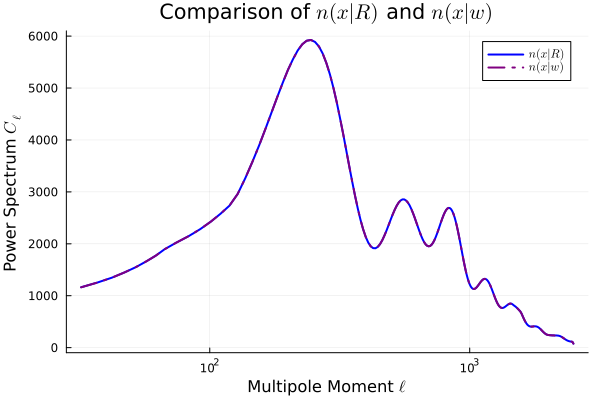

In [37]:
using Plots
using LaTeXStrings

# Obtain the adjusted predictions from the trained model (using mlpd_full instead of mlpd_cropped)
predictions_adjusted = vec(mlpd(X_train))

# Calculate n(x | w) = n(x | R) * f(x, w)
nx_w = y_train .* predictions_adjusted
normed_nx_r = y_train .* (lmean .* (lmean .+ 1) ./ (2 * π))
normed_nx_w = nx_w .* (lmean .* (lmean .+ 1) ./ (2 * π))

# Create the comparative plot using the full variables
p = plot(lmean, normed_nx_r, label=L"$n(x|R)$", lw=2, color=:blue, xscale=:log10)
plot!(p, lmean, normed_nx_w, label=L"$n(x|w)$", lw=2, linestyle=:dashdot, color=:purple, xscale=:log10)

# Labels and title
xlabel!(L"Multipole Moment $\ell$")
ylabel!(L"Power Spectrum $C_{\ell}$")
title!(L"Comparison of $n(x | R)$ and $n(x | w)$")

# Define legend position
plot!(p, legend=:topright)

# Display the plot
display(p)


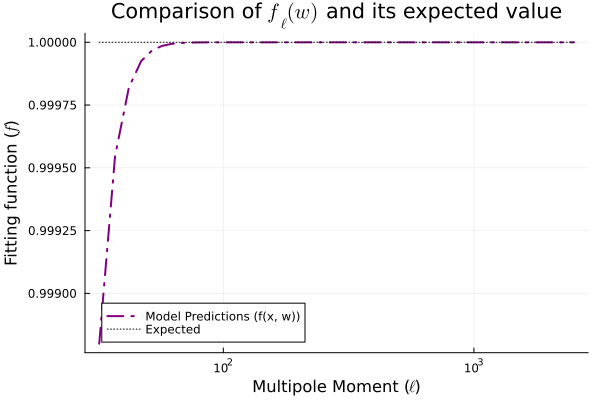

In [38]:
# Create the comparative plot using the full variables
p = plot(lmean, predictions_adjusted, label="Model Predictions (f(x, w))", lw=2, linestyle=:dashdot, color=:purple, xscale=:log10)
plot!(p, lmean, ones(length(lmean)), lw=1, linestyle=:dot, color=:black, label="Expected")

# Labels and title
xlabel!(L"Multipole Moment ($\ell$)")
ylabel!(L"Fitting function ($f$)")
title!(L"Comparison of $f_\ell(w)$ and its expected value")

# Define legend position
plot!(p, legend=:bottomleft)

# Display the plot
display(p)


Apart from some jumping around during training, which would be nice to understand, things converge to $f=1$ as expected.

# Train against noisy data

A more interesting case is when the data are a noisy representation of the reference model. In this case the approximant will fit the noise and give a $t$ value.

The distribution of those $t$ values will allow us to obtain the $p$ value of a given observation.

We compute it for a single realization of the noise to start with.

In [39]:
fake_data = randClTT_matrix[:,7]

215-element Vector{Float64}:
 7.185086913952574
 5.401525339892481
 4.397936597679684
 4.328244085870003
 3.7740058116451256
 2.8550217669980533
 3.037540798212802
 2.572043830615004
 2.2923323168043837
 2.031918580515581
 1.735020302439081
 1.6146543701120175
 1.4424599168469032
 ⋮
 0.00024606332760178915
 0.0002110284503804841
 0.0001733728866886624
 0.0001591662707420177
 0.0001326178990796599
 0.0001346099809597546
 0.00012293829658693612
 0.00011328649135183723
 0.00010062916458547482
 0.00010632379646620908
 0.00010662078009958929
 9.443322484523e-5

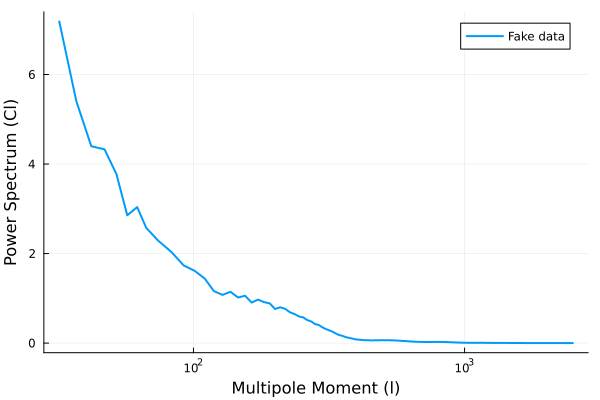

In [40]:

# Plot Cltt_matrix_avg and data on the same scale
plot(lmean, fake_data, label="Fake data", xscale=:log10, lw=2)

# Set labels and title
xlabel!("Multipole Moment (l)")
ylabel!("Power Spectrum (Cl)")


In [42]:
using Flux

y_train = fake_data

# Create the adjusted model
mlpd = Chain(
    Dense(1 => 10, Flux.sigmoid),
    Dense(10 => 1)
)

# Begin optimization
opt = Flux.AdamW(1e-3, (0.99, 0.999))
epochs = 40_000
losses = Float64[]

for epoch in 1:epochs
    gs = gradient(() -> neg_log_likelihood_ratio(mlpd, X_train, y_train, inv_covTT, n_R), Flux.params(mlpd))
    Flux.Optimise.update!(opt, Flux.params(mlpd), gs)
    current_loss = neg_log_likelihood_ratio(mlpd, X_train, y_train, inv_covTT, n_R)
    if epoch%1000 == 0
        push!(losses, current_loss)
        println("Epoch $epoch completed, Loss: ", current_loss)
    end
end


Epoch 1000 completed, Loss: 1.2515040642404542
Epoch 2000 completed, Loss: -0.21742803240486247
Epoch 3000 completed, Loss: -0.2321045464370668
Epoch 4000 completed, Loss: -0.24332456542486808
Epoch 5000 completed, Loss: -0.25266603717481645
Epoch 6000 completed, Loss: -0.2609439213170336
Epoch 7000 completed, Loss: -0.2689637313097684
Epoch 8000 completed, Loss: -0.2768089100253473
Epoch 9000 completed, Loss: -0.28295583015986964
Epoch 10000 completed, Loss: -0.2889580037466807
Epoch 11000 completed, Loss: -0.29578080566496545
Epoch 12000 completed, Loss: -0.30459922566095765
Epoch 13000 completed, Loss: -0.31715600237812486
Epoch 14000 completed, Loss: -0.3349531084117634
Epoch 15000 completed, Loss: -0.35630210961124364
Epoch 16000 completed, Loss: -0.3770333626874112
Epoch 17000 completed, Loss: -0.39423655841227667
Epoch 18000 completed, Loss: -0.40709774675094057
Epoch 19000 completed, Loss: -0.4160677740326682
Epoch 20000 completed, Loss: -0.4220154377271319
Epoch 21000 complete

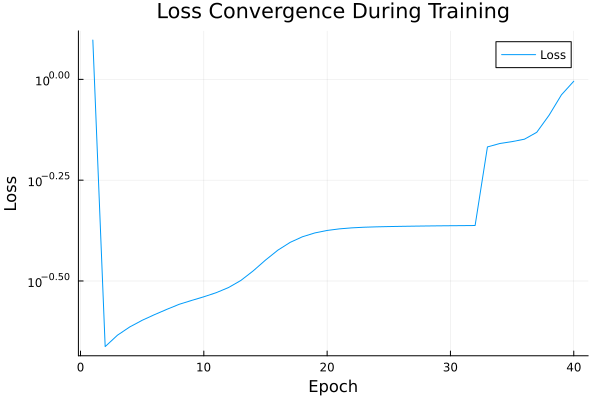

In [43]:
# Plot the loss
using Plots
plot(
    1:length(losses), abs.(losses),
    yscale=:log10,
    label="Loss", 
    xlabel="Epoch", 
    ylabel="Loss", 
    title="Loss Convergence During Training"
)

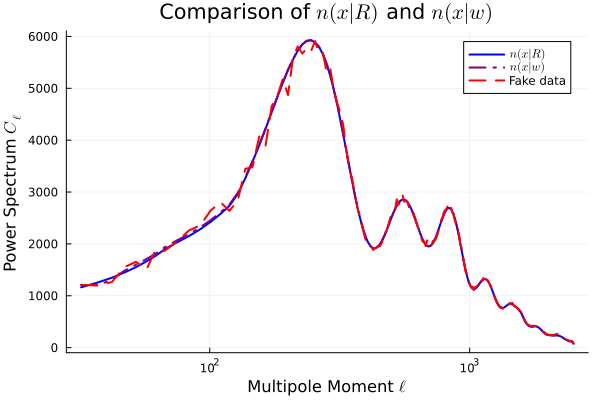

In [44]:
using Plots
using LaTeXStrings

# Obtain the adjusted predictions from the trained model (using mlpd_full instead of mlpd_cropped)
predictions_adjusted = vec(mlpd(X_train))

# Calculate n(x | w) = n(x | R) * f(x, w)
nx_w = n_R .* predictions_adjusted
normed_n_R = n_R .* (lmean .* (lmean .+ 1) ./ (2 * π))
normed_nx_w = nx_w .* (lmean .* (lmean .+ 1) ./ (2 * π))
normed_y_train = y_train .* (lmean .* (lmean .+ 1) ./ (2 * π))

# Create the comparative plot using the full variables
p = plot(lmean, normed_nx_r, label=L"$n(x|R)$", lw=2, color=:blue, xscale=:log10)
plot!(p, lmean, normed_nx_w, label=L"$n(x|w)$", lw=2, linestyle=:dashdot, color=:purple, xscale=:log10)
plot!(p, lmean, normed_y_train, label="Fake data", lw=2, linestyle=:dash, color=:red, xscale=:log10)

# Labels and title
xlabel!(L"Multipole Moment $\ell$")
ylabel!(L"Power Spectrum $C_{\ell}$")
title!(L"Comparison of $n(x | R)$ and $n(x | w)$")

# Define legend position
plot!(p, legend=:topright)

# Display the plot
display(p)


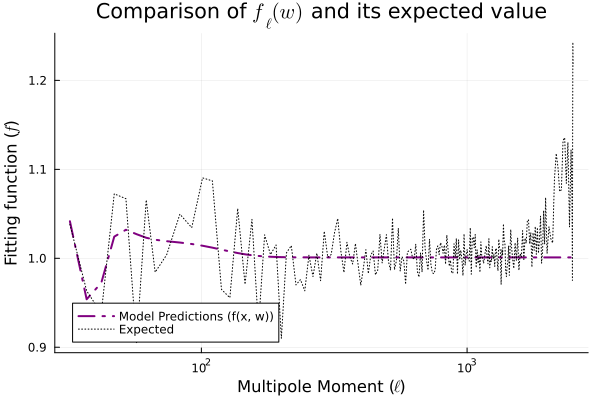

In [45]:
# Create the comparative plot using the full variables
p = plot(lmean, predictions_adjusted, label="Model Predictions (f(x, w))", lw=2, linestyle=:dashdot, color=:purple, xscale=:log10)
plot!(p, lmean, fake_data./n_R, lw=1, linestyle=:dot, color=:black, label="Expected")

# Labels and title
xlabel!(L"Multipole Moment ($\ell$)")
ylabel!(L"Fitting function ($f$)")
title!(L"Comparison of $f_\ell(w)$ and its expected value")

# Define legend position
plot!(p, legend=:bottomleft)

# Display the plot
display(p)


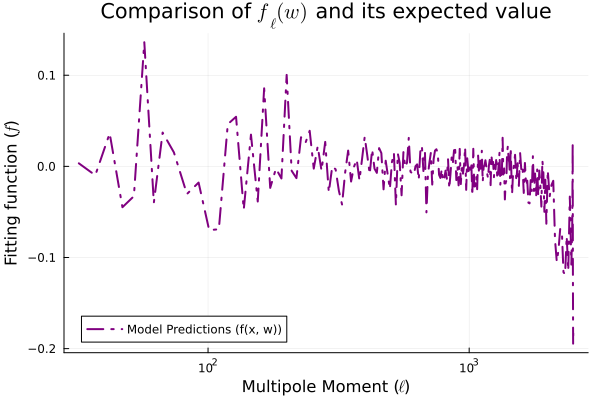

In [46]:

# Create the comparative plot using the full variables
p = plot(lmean, predictions_adjusted./(fake_data./n_R) .- 1, label="Model Predictions (f(x, w))", lw=2, linestyle=:dashdot, color=:purple, xscale=:log10)

# Labels and title
xlabel!(L"Multipole Moment ($\ell$)")
ylabel!(L"Fitting function ($f$)")
title!(L"Comparison of $f_\ell(w)$ and its expected value")

# Define legend position
plot!(p, legend=:bottomleft)

# Display the plot
display(p)


# Distribution of $t$ values

Now we want to obtain the distribution of $t$ values from noise realizations.

In [47]:
using Flux

# Create the adjusted model
mlpd = Chain(
    Dense(1 => 4, Flux.sigmoid),
    Dense(4 => 1)
)

function get_t_value(data, model, epochs=1000, print_output=false)

    # Begin optimization
    opt = Flux.AdamW(1e-3, (0.99, 0.999))
    losses = Float64[]

    y_train = data
    current_loss = 0

    for epoch in 1:epochs
        gs = gradient(() -> neg_log_likelihood_ratio(mlpd, X_train, y_train, inv_covTT, n_R), Flux.params(mlpd))
        Flux.Optimise.update!(opt, Flux.params(mlpd), gs)
        current_loss = neg_log_likelihood_ratio(mlpd, X_train, y_train, inv_covTT, n_R)
        if print_output
            println("Epoch $epoch completed, Loss: ", current_loss)
        end
    end

    return current_loss

end

get_t_value (generic function with 3 methods)

In [ ]:
t_vals = [get_t_value(randClTT_matrix[:,i], mlpd, 40_000) for i in 1:100]

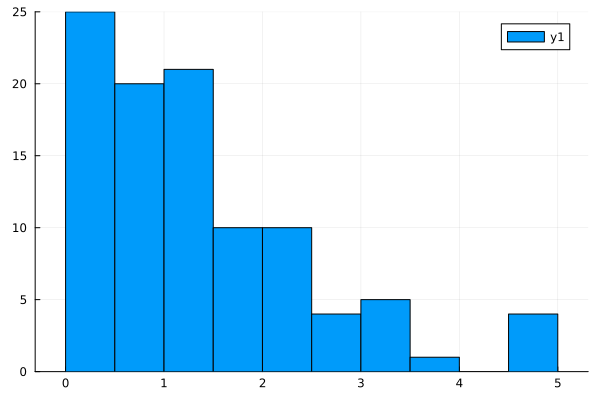

In [89]:
using Plots

histogram(-t_vals)

# Appendixes: 

## A neural net as an universal approximant

Our models with many parameters are not fitting the noise. This is strange, as we expect that with increasing number of parameters the neural net can fit any function. Furthermore, we expect the $t$ values to be of the order of the number of parameters at least for numbers of parameters below the number of bins. 

To solve this, we explore the properties of the neural nets as universal approximants.

First, a simple example: A neural net can fit a $cos$.

In [38]:
using Flux

X_train = rand!(zeros(1000)).*(2*pi) .- pi
y_train = sin.(X_train)

X_test = rand!(zeros(100)).*(2*pi) .- pi
y_test = sin.(X_test)

X_val = rand!(zeros(100)).*(2*pi) .- pi
y_val = sin.(X_val)

mlpd = Chain(
    Dense(1 => 100, Flux.sigmoid),
    Dense(100 => 1)
)

Chain(
  Dense(1 => 100, σ),                   # 200 parameters
  Dense(100 => 1),                      # 101 parameters
)                   # Total: 4 arrays, 301 parameters, 1.426 KiB.

In [39]:
epochs = 1000
losses = Float64[]
opt = Flux.ADAM(0.05)

function difference_loss(model, X, y)
    return sum((model(reshape(X, 1, :))[:] .- y).^2)
end

for epoch in 1:epochs
    gs = gradient(() -> difference_loss(mlpd, X_train, y_train), Flux.params(mlpd))
    Flux.Optimise.update!(opt, Flux.params(mlpd), gs)
    current_loss = difference_loss(mlpd, X_train, y_train)
    push!(losses, current_loss)
    println("Epoch $epoch completed, Loss: ", current_loss)
end

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(1 => 100, σ)  # 200 parameters
│   summary(x) = "1×1000 Matrix{Float64}"
└ @ Flux ~/.julia/packages/Flux/MtsAN/src/layers/stateless.jl:60


Epoch 1 completed, Loss: 3118.963890611701
Epoch 2 completed, Loss: 966.6378725765313
Epoch 3 completed, Loss: 337.0256462571138
Epoch 4 completed, Loss: 1459.0959327542923
Epoch 5 completed, Loss: 1309.0411965153487
Epoch 6 completed, Loss: 478.2283813755952
Epoch 7 completed, Loss: 340.1525769370682
Epoch 8 completed, Loss: 792.9679156577853
Epoch 9 completed, Loss: 898.5400421312831
Epoch 10 completed, Loss: 513.0156770554353
Epoch 11 completed, Loss: 205.51428082345163
Epoch 12 completed, Loss: 314.8303893692729
Epoch 13 completed, Loss: 580.2189233299965
Epoch 14 completed, Loss: 602.4930011969051
Epoch 15 completed, Loss: 385.2788152622202
Epoch 16 completed, Loss: 223.0469489579601
Epoch 17 completed, Loss: 277.6319218319596
Epoch 18 completed, Loss: 411.0720870341474
Epoch 19 completed, Loss: 415.74119447560395
Epoch 20 completed, Loss: 288.5096445432495
Epoch 21 completed, Loss: 192.74672213247692
Epoch 22 completed, Loss: 227.7043825201278
Epoch 23 completed, Loss: 317.416310

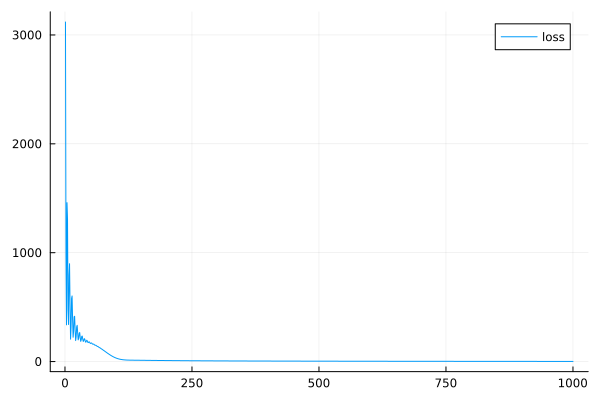

In [40]:
using Plots 

plot(1:epochs, losses, label="loss")

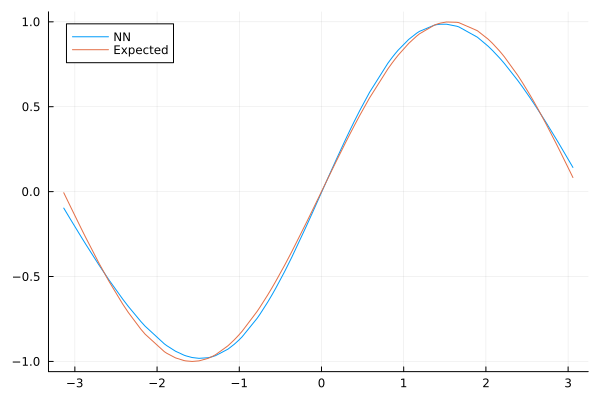

In [41]:
X_test = sort(X_test)
y_plot = sin.(X_test)
y_pred = mlpd(reshape(X_test, 1, :))[:]

using Plots 

plot(X_test, y_pred, label="NN")
plot!(X_test, y_plot, label="Expected")

A first question is whether our loss makes convergence difficult. So we repeat the above with our loss, where the reference model is just an array of ones.

In [42]:
mlpd = Chain(
    Dense(1 => 100, Flux.sigmoid),
    Dense(100 => 1)
)

epochs = 1000
losses = Float64[]
opt = Flux.ADAM(0.05)

n_R = ones(length(X_train))

function neg_log_likelihood_ratio_test(model, X, y)
    # Predictions from the trained model
    f_x_w = model(reshape(X, 1, :))[:]
    
    return -n_R' * (2(Diagonal(f_x_w .- 1)) * y - 
             (Diagonal(f_x_w) * Diagonal(f_x_w) - I)*n_R)/2
end

for epoch in 1:epochs
    gs = gradient(() -> neg_log_likelihood_ratio_test(mlpd, X_train, y_train), Flux.params(mlpd))
    Flux.Optimise.update!(opt, Flux.params(mlpd), gs)
    current_loss = neg_log_likelihood_ratio_test(mlpd, X_train, y_train)
    push!(losses, current_loss)
    println("Epoch $epoch completed, Loss: ", current_loss)
end

Epoch 1 completed, Loss: 1227.7563780859844
Epoch 2 completed, Loss: -415.66408837374854
Epoch 3 completed, Loss: -377.45969450512973
Epoch 4 completed, Loss: 281.8671873093159
Epoch 5 completed, Loss: -52.252394469001885
Epoch 6 completed, Loss: -583.9415991571921
Epoch 7 completed, Loss: -579.7043123088116
Epoch 8 completed, Loss: -264.06958325471834
Epoch 9 completed, Loss: -210.73255963696775
Epoch 10 completed, Loss: -451.9840873274367
Epoch 11 completed, Loss: -643.0596640278973
Epoch 12 completed, Loss: -587.1186158870374
Epoch 13 completed, Loss: -428.13695100888305
Epoch 14 completed, Loss: -404.86214421182336
Epoch 15 completed, Loss: -537.3044836218118
Epoch 16 completed, Loss: -658.7115690201623
Epoch 17 completed, Loss: -646.7565592335044
Epoch 18 completed, Loss: -552.2549812726284
Epoch 19 completed, Loss: -510.4063025294925
Epoch 20 completed, Loss: -567.8828756539319
Epoch 21 completed, Loss: -648.3175093810879
Epoch 22 completed, Loss: -664.1345561030168
Epoch 23 comp

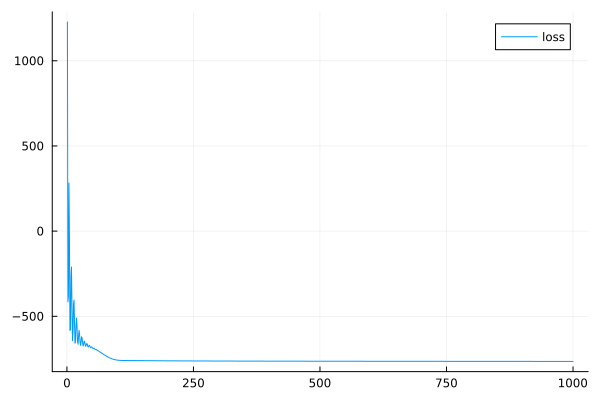

In [43]:
using Plots 

plot(1:epochs, losses, label="loss")

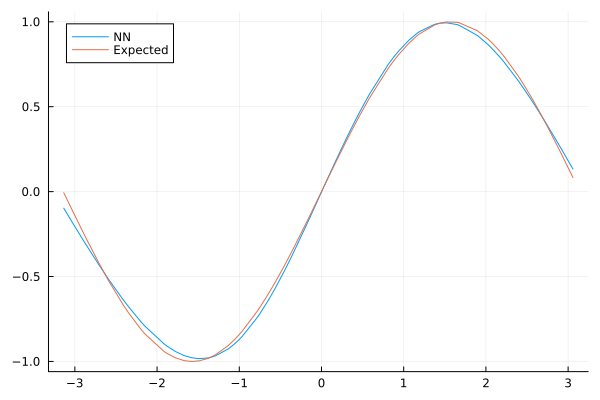

In [44]:
X_test = sort(X_test)
y_plot = sin.(X_test)
y_pred = mlpd(reshape(X_test, 1, :))[:]

using Plots 

plot(X_test, y_pred, label="NN")
plot!(X_test, y_plot, label="Expected")

Another question is whether it's some characteristic of the noise that makes it difficult for the neural net to fit it. So we repeat the above for a constant plus the noise. Going back to the squared error loss.

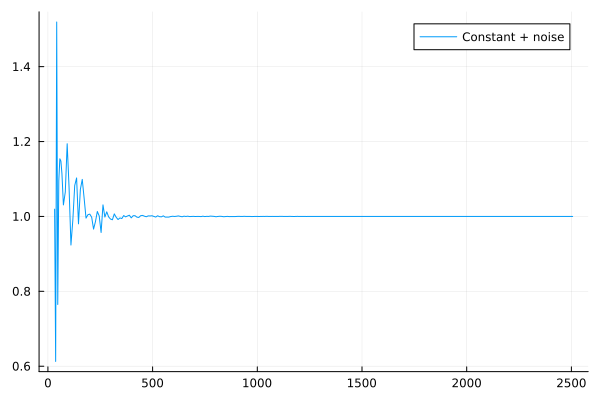

In [45]:
using Flux
using Plots

X_train = reshape(lmean, 1, :)
y_train = ones(length(X_train)) + randerr[1]

plot(X_train[:], y_train, label="Constant + noise")

In [46]:
mlpd = Chain(
    Dense(1 => 1000, Flux.sigmoid),
    Dense(1000 => 1)
)

epochs = 4000
losses = Float64[]
opt = Flux.AMSGrad(1e-4)
#opt = Flux.NAdam()
#opt = Flux.AdaBelief()

function difference_loss(model, X, y)
    return sum((model(X)[:] .- y).^2)
end

for epoch in 1:epochs
    gs = gradient(() -> difference_loss(mlpd, X_train, y_train), Flux.params(mlpd))
    Flux.Optimise.update!(opt, Flux.params(mlpd), gs)
    current_loss = difference_loss(mlpd, X_train, y_train)
    push!(losses, current_loss)
    println("Epoch $epoch completed, Loss: ", current_loss)
end

Epoch 1 completed, Loss: 570.9385956137638
Epoch 2 completed, Loss: 363.64623585971214
Epoch 3 completed, Loss: 182.85527934958102
Epoch 4 completed, Loss: 57.53844327170877
Epoch 5 completed, Loss: 2.7123123348215006
Epoch 6 completed, Loss: 20.179987528257147
Epoch 7 completed, Loss: 78.6576971145721
Epoch 8 completed, Loss: 127.75586277064163
Epoch 9 completed, Loss: 149.13829703369302
Epoch 10 completed, Loss: 144.8926575903969
Epoch 11 completed, Loss: 123.48932306797164
Epoch 12 completed, Loss: 93.97207277771597
Epoch 13 completed, Loss: 63.646128857769064
Epoch 14 completed, Loss: 37.336228896891846
Epoch 15 completed, Loss: 17.734475756147575
Epoch 16 completed, Loss: 5.773738955440069
Epoch 17 completed, Loss: 0.9417667049170314
Epoch 18 completed, Loss: 1.773591935696826
Epoch 19 completed, Loss: 6.278931583033104
Epoch 20 completed, Loss: 12.346753197932182
Epoch 21 completed, Loss: 18.10626265454349
Epoch 22 completed, Loss: 22.203608099035566
Epoch 23 completed, Loss: 23.

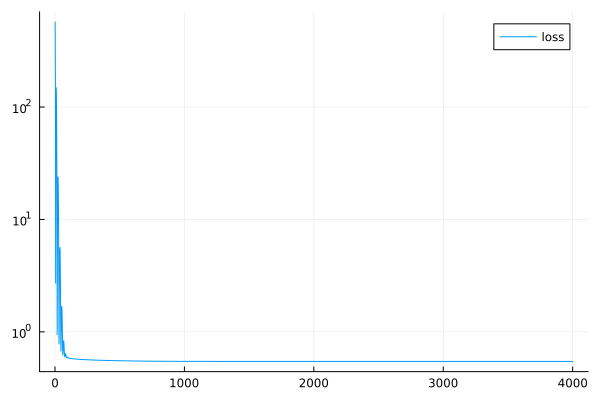

In [47]:
using Plots 

plot(1:epochs, losses, label="loss", yscale=:log10)

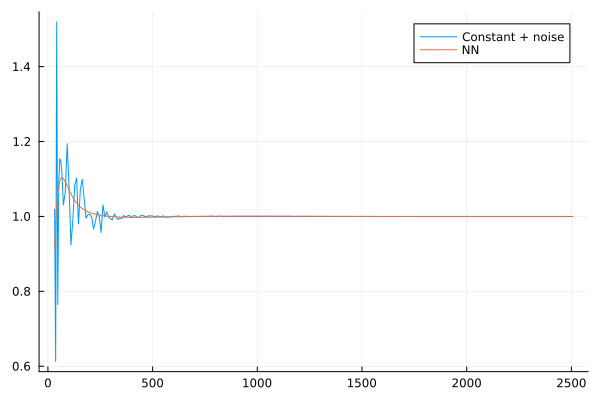

In [48]:
using Plots 

y_pred = mlpd(X_train)[:]

plot(X_train[:], y_train, label="Constant + noise")
plot!(X_train[:], y_pred, label="NN")

We see something similar to what we see above. There seems to be some assumption about the smoothness of the function when talking about neural nets as universal approximants.

We tried with different sizes for the hidden layer, between 100 and 1000, always obtaining similar results. Though simpler models did tend to slightly fit the noise.

We also tried different optimizers. The optimizer does change the results, with some better approaching the noise. But they always give rather smooth functions.

It could also be that it finds a local minimum and stops there, not exploring close to a global minimum.

What we show below is that this happens (with quadratic loss) because the convergence is slow. The network does try to fit the noise if you train for long enough.

### Computing the optimal weights by hand

We can approximate any function with steps. The general formula is

$$
y_{out} = \sum_i \delta F_i \sigma(w\cdot(x - X_i))\,,
$$

where $X_i$ is the training locations, and $\delta F_i$ is the jump at each step. The other parameter $w$ simply controls the width of the jump.

Note that this is suboptimal, since it uses more parameters than necessary. But it does the job of approximating any function on a set of points *exactly*.

Following the above, the weights for the hidden layer are all $w$, the biases are all $w X_i$, the weights for the output layer are $\delta F_i$, and the biases are zero.

In [49]:
by_hand = Chain(
    Dense(1 => length(y_train), Flux.sigmoid),
    Dense(length(y_train) => 1)
)

Chain(
  Dense(1 => 215, σ),                   # 430 parameters
  Dense(215 => 1),                      # 216 parameters
)                   # Total: 4 arrays, 646 parameters, 2.773 KiB.

In [50]:
dF = similar(y_train)
dF[1] = y_train[1]
for i in 2:length(y_train)
    dF[i] = y_train[i] - y_train[i-1]
end

In [51]:
# Compute the weights by hand

theta, re = Flux.destructure(by_hand)

w = 100

for i in 1:length(y_train)
    theta[i] = w
end

for i in (length(y_train) + 1):(2*length(y_train))
    theta[i] = -(w*X_train[i - length(y_train)] - 2.5)
end

for i in (2*length(y_train) + 1):(3*length(y_train))
    theta[i] = dF[i - 2*length(y_train)]
end

by_hand = re(theta)

Chain(
  Dense(1 => 215, σ),                   # 430 parameters
  Dense(215 => 1),                      # 216 parameters
)                   # Total: 4 arrays, 646 parameters, 2.773 KiB.

In [52]:
Flux.params(by_hand)

Params([Float32[100.0; 100.0; … ; 100.0; 100.0;;], Float32[-3197.5, -3697.5, -4197.5, -4697.5, -5197.5, -5697.5, -6197.5, -6697.5, -7397.5, -8297.5  …  -236297.5, -239597.5, -242897.5, -246197.5, -248097.5, -248597.5, -249097.5, -249597.5, -250097.5, -250597.5], Float32[1.0193756 -0.40661317 … -2.3482255f-5 -8.6722275f-6], Float32[0.0]])

In [54]:

gradient_model = Chain(
    Dense(1 => length(y_train), Flux.sigmoid),
    Dense(length(y_train) => 1)
)

epochs = 800_000
losses = Float64[]
# for 800_000 epochs
#opt = Flux.Descent() # gives NaN
#opt = Flux.Momentum() # gives NaN
#opt = Flux.Nesterov() # gives NaN
#opt = Flux.AdaDelta() # Huge loss, jumps around
#opt = Flux.RMSProp() # very slow convergence
#opt = Flux.NAdam() # ok 0.869, got stuck when ran for 100_000 epochs
#opt = Flux.AdaGrad() # ok 0.583, lost to others at 100_000
#opt = Flux.ADAM() # ok, 0.564, lost to others at 100_000
#opt = Flux.AdamW() # ok 0.138, lost to aMSGrad at 400_000, and seems similar, threw it
#opt = Flux.AdaMax() # ok 0.310, lost to others at 400_000, but seems to fall off faster towards the end, kept it
opt = Flux.AMSGrad() # ok 0.028 Works best for this loss! 

function difference_loss(model, X, y)
    return sum((model(X)[:] .- y).^2)
end

for epoch in 1:epochs
    gs = gradient(() -> difference_loss(gradient_model, X_train, y_train), Flux.params(gradient_model))
    Flux.Optimise.update!(opt, Flux.params(gradient_model), gs)
    current_loss = difference_loss(gradient_model, X_train, y_train)
    if epoch%1000 == 0
        push!(losses, current_loss)
        println("Epoch $epoch completed, Loss: ", current_loss)
    end
end

Epoch 1000 completed, Loss: 0.545103282234926
Epoch 2000 completed, Loss: 0.5443888900036419
Epoch 3000 completed, Loss: 0.5438871748713515
Epoch 4000 completed, Loss: 0.543273431843885
Epoch 5000 completed, Loss: 0.542023148577239
Epoch 6000 completed, Loss: 0.5392566088037359
Epoch 7000 completed, Loss: 0.5351566674943504
Epoch 8000 completed, Loss: 0.5301791321321344
Epoch 9000 completed, Loss: 0.5244172367453719
Epoch 10000 completed, Loss: 0.5177564136501258
Epoch 11000 completed, Loss: 0.5092769486988298
Epoch 12000 completed, Loss: 0.4977374407548384
Epoch 13000 completed, Loss: 0.48399931803098933
Epoch 14000 completed, Loss: 0.4701846160061608
Epoch 15000 completed, Loss: 0.45681536438407516
Epoch 16000 completed, Loss: 0.44525294932476867
Epoch 17000 completed, Loss: 0.43383157480564094
Epoch 18000 completed, Loss: 0.42470978740731125
Epoch 19000 completed, Loss: 0.4158244213195187
Epoch 20000 completed, Loss: 0.40808931278757193
Epoch 21000 completed, Loss: 0.400590273464458

In [55]:
print("Loss with gradient descent: $(difference_loss(gradient_model, X_train, y_train)), loss by hand $(difference_loss(by_hand, X_train, y_train))")

Loss with gradient descent: 0.017973310985453086, loss by hand 0.01626263236245702

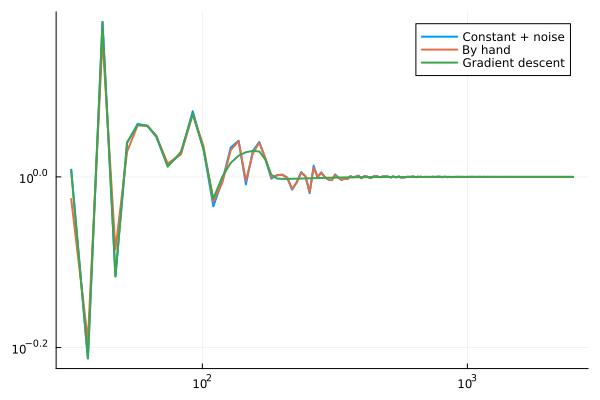

In [56]:
using Plots 

y_pred_hand = by_hand(X_train)[:]
y_pred_grad = gradient_model(X_train)[:]

plot(X_train[:], y_train, width=2, yscale=:log10, xscale=:log10, label="Constant + noise")
plot!(X_train[:], y_pred_hand, width=2, yscale=:log10, xscale=:log10, label="By hand")
plot!(X_train[:], y_pred_grad, width=2, yscale=:log10, xscale=:log10, label="Gradient descent")
#savefig("noise.png")

As we can see, the gradient descent reaches the minimum very slowly. We have to train the network for a very long time.

Now, let's repeat the experiment with the other loss.

In [57]:
n_R = ones(length(X_train))

function neg_log_likelihood_ratio_test(model, X, y)
    # Predictions from the trained model
    f_x_w = model(X)[:]
    
    return -n_R' * (2(Diagonal(f_x_w .- 1)) * y - 
             (Diagonal(f_x_w) * Diagonal(f_x_w) - I)*n_R)/2
end

neg_log_likelihood_ratio_test (generic function with 1 method)

In [58]:
neg_log_likelihood_ratio_test(by_hand, X_train, y_train)

-0.31075532943757767

In [59]:
gradient_model = Chain(
    Dense(1 => length(y_train), Flux.sigmoid),
    Dense(length(y_train) => 1)
)

epochs = 100_000
losses = Float64[]
# for 100_000 epochs
# opt = Flux.Descent() # gives NaN 
# opt = Flux.Momentum() # gives NaN
# opt = Flux.Nesterov() # gives NaN
# opt = Flux.AdaDelta() # large loss
# opt = Flux.RMSProp() # 0.20 eliminated at 100_000 epochs
# opt = Flux.NAdam() # Seems stuck at around -0.031, eliminated at 100_000 epochs
# opt = Flux.ADAM() # -0.14, eliminated at 100_000 epochs
# opt = Flux.AdaGrad() # -0.18
# opt = Flux.AdamW() # -0.21
opt = Flux.AMSGrad() # -0.28
# opt = Flux.AdaMax() # -0.17

for epoch in 1:epochs
    gs = gradient(() -> neg_log_likelihood_ratio_test(gradient_model, X_train, y_train), Flux.params(gradient_model))
    Flux.Optimise.update!(opt, Flux.params(gradient_model), gs)
    current_loss = neg_log_likelihood_ratio_test(gradient_model, X_train, y_train)
    if epoch%1000 == 0
        push!(losses, current_loss)
        println("Epoch $epoch completed, Loss: ", current_loss)
    end
end

Epoch 1000 completed, Loss: -0.04662979017168297
Epoch 2000 completed, Loss: -0.04713426128188046
Epoch 3000 completed, Loss: -0.047648276657917536
Epoch 4000 completed, Loss: -0.04840607094710292
Epoch 5000 completed, Loss: -0.05001235089427008
Epoch 6000 completed, Loss: -0.05266954804367956
Epoch 7000 completed, Loss: -0.05632631478217816
Epoch 8000 completed, Loss: -0.06158185840360858
Epoch 9000 completed, Loss: -0.06754539985167228
Epoch 10000 completed, Loss: -0.07354554343569406
Epoch 11000 completed, Loss: -0.0795204774588805
Epoch 12000 completed, Loss: -0.08538950747178979
Epoch 13000 completed, Loss: -0.09155371586555595
Epoch 14000 completed, Loss: -0.09784699706081855
Epoch 15000 completed, Loss: -0.10778510248480515
Epoch 16000 completed, Loss: -0.11712884317232256
Epoch 17000 completed, Loss: -0.12548775456540692
Epoch 18000 completed, Loss: -0.13298257928242732
Epoch 19000 completed, Loss: -0.14000150672386721
Epoch 20000 completed, Loss: -0.1464067917187794
Epoch 2100

In [60]:
print("Loss with gradient descent: $(neg_log_likelihood_ratio_test(gradient_model, X_train, y_train)), loss by hand $(neg_log_likelihood_ratio_test(by_hand, X_train, y_train))")

Loss with gradient descent: -0.2864526290179982, loss by hand -0.31075532943757767

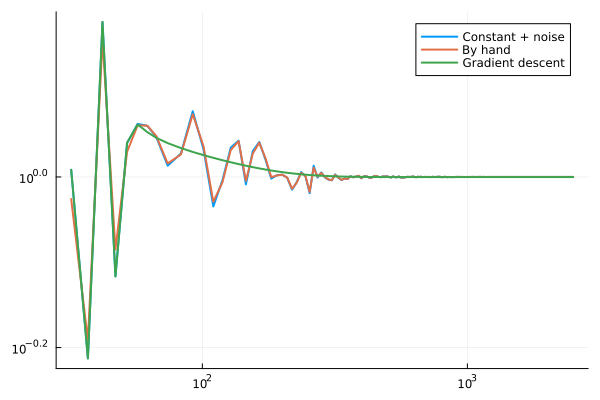

In [61]:
using Plots 

y_pred_opt = by_hand(X_train)[:]
y_pred_subopt = gradient_model(X_train)[:]

plot(X_train[:], y_train, width=2, yscale=:log10, xscale=:log10, label="Constant + noise")
plot!(X_train[:], y_pred_opt, width=2, yscale=:log10, xscale=:log10, label="By hand")
plot!(X_train[:], y_pred_subopt, width=2, yscale=:log10, xscale=:log10, label="Gradient descent")

In [62]:
function train(epochs, opt)

    gradient_model = Chain(
        Dense(1 => length(y_train), Flux.sigmoid),
        Dense(length(y_train) => 1)
    )

    best_loss = neg_log_likelihood_ratio_test(gradient_model, X_train, y_train)
    best_model = gradient_model

    for epoch in 1:epochs
        gs = gradient(() -> neg_log_likelihood_ratio_test(gradient_model, X_train, y_train), Flux.params(gradient_model))
        Flux.Optimise.update!(opt, Flux.params(gradient_model), gs)
        current_loss = neg_log_likelihood_ratio_test(gradient_model, X_train, y_train)
        if current_loss < best_loss
            best_loss = current_loss
            best_model = gradient_model
        end
    end

    println(best_loss)
    return best_model, best_loss
end

train (generic function with 1 method)

In [63]:
grid_to_search = [
    (Flux.AdaGrad(0.5), "Flux.AdaGrad(0.5)"),
    (Flux.AdaGrad(1e-3), "Flux.AdaGrad(1e-3)"),
    (Flux.AdaGrad(1e-5), "Flux.AdaGrad(1e-5)"),
    (Flux.AdamW(1e-5, (0.7, 0.9)), "Flux.AdamW(1e-5, (0.7, 0.9))"),
    (Flux.AdamW(1e-5, (0.7, 0.999)), "Flux.AdamW(1e-5, (0.7, 0.999))"),
    (Flux.AdamW(1e-5, (0.7, 0.99999)), "Flux.AdamW(1e-5, (0.7, 0.99999))"),
    (Flux.AdamW(1e-5, (0.9, 0.9)), "Flux.AdamW(1e-5, (0.9, 0.9))"),
    (Flux.AdamW(1e-5, (0.9, 0.999)), "Flux.AdamW(1e-5, (0.9, 0.999))"),
    (Flux.AdamW(1e-5, (0.9, 0.99999)), "Flux.AdamW(1e-5, (0.9, 0.99999))"),
    (Flux.AdamW(1e-5, (0.99, 0.9)), "Flux.AdamW(1e-5, (0.99, 0.9))"),
    (Flux.AdamW(1e-5, (0.99, 0.999)), "Flux.AdamW(1e-5, (0.99, 0.999))"),
    (Flux.AdamW(1e-5, (0.99, 0.99999)), "Flux.AdamW(1e-5, (0.99, 0.99999))"),
    (Flux.AdamW(1e-3, (0.7, 0.9)), "Flux.AdamW(1e-3, (0.7, 0.9))"),
    (Flux.AdamW(1e-3, (0.7, 0.999)), "Flux.AdamW(1e-3, (0.7, 0.999))"),
    (Flux.AdamW(1e-3, (0.7, 0.99999)), "Flux.AdamW(1e-3, (0.7, 0.99999))"),
    (Flux.AdamW(1e-3, (0.9, 0.9)), "Flux.AdamW(1e-3, (0.9, 0.9))"),
    (Flux.AdamW(1e-3, (0.9, 0.999)), "Flux.AdamW(1e-3, (0.9, 0.999))"),
    (Flux.AdamW(1e-3, (0.9, 0.99999)), "Flux.AdamW(1e-3, (0.9, 0.99999))"),
    (Flux.AdamW(1e-3, (0.99, 0.9)), "Flux.AdamW(1e-3, (0.99, 0.9))"),
    (Flux.AdamW(1e-3, (0.99, 0.999)), "Flux.AdamW(1e-3, (0.99, 0.999))"),
    (Flux.AdamW(1e-3, (0.99, 0.99999)), "Flux.AdamW(1e-3, (0.99, 0.99999))"),
    (Flux.AdamW(0.1, (0.7, 0.9)), "Flux.AdamW(0.1, (0.7, 0.9))"),
    (Flux.AdamW(0.1, (0.7, 0.999)), "Flux.AdamW(0.1, (0.7, 0.999))"),
    (Flux.AdamW(0.1, (0.7, 0.99999)), "Flux.AdamW(0.1, (0.7, 0.99999))"),
    (Flux.AdamW(0.1, (0.9, 0.9)), "Flux.AdamW(0.1, (0.9, 0.9))"),
    (Flux.AdamW(0.1, (0.9, 0.999)), "Flux.AdamW(0.1, (0.9, 0.999))"),
    (Flux.AdamW(0.1, (0.9, 0.99999)), "Flux.AdamW(0.1, (0.9, 0.99999))"),
    (Flux.AdamW(0.1, (0.99, 0.9)), "Flux.AdamW(0.1, (0.99, 0.9))"),
    (Flux.AdamW(0.1, (0.99, 0.999)), "Flux.AdamW(0.1, (0.99, 0.999))"),
    (Flux.AdamW(0.1, (0.99, 0.99999)), "Flux.AdamW(0.1, (0.99, 0.99999))"),
    (Flux.AMSGrad(1e-5, (0.7, 0.9)), "Flux.AMSGrad(1e-5, (0.7, 0.9))"),
    (Flux.AMSGrad(1e-5, (0.7, 0.999)), "Flux.AMSGrad(1e-5, (0.7, 0.999))"),
    (Flux.AMSGrad(1e-5, (0.7, 0.99999)), "Flux.AMSGrad(1e-5, (0.7, 0.99999))"),
    (Flux.AMSGrad(1e-5, (0.9, 0.9)), "Flux.AMSGrad(1e-5, (0.9, 0.9))"),
    (Flux.AMSGrad(1e-5, (0.9, 0.999)), "Flux.AMSGrad(1e-5, (0.9, 0.999))"),
    (Flux.AMSGrad(1e-5, (0.9, 0.99999)), "Flux.AMSGrad(1e-5, (0.9, 0.99999))"),
    (Flux.AMSGrad(1e-5, (0.99, 0.9)), "Flux.AMSGrad(1e-5, (0.99, 0.9))"),
    (Flux.AMSGrad(1e-5, (0.99, 0.999)), "Flux.AMSGrad(1e-5, (0.99, 0.999))"),
    (Flux.AMSGrad(1e-5, (0.99, 0.99999)), "Flux.AMSGrad(1e-5, (0.99, 0.99999))"),
    (Flux.AMSGrad(1e-3, (0.7, 0.9)), "Flux.AMSGrad(1e-3, (0.7, 0.9))"),
    (Flux.AMSGrad(1e-3, (0.7, 0.999)), "Flux.AMSGrad(1e-3, (0.7, 0.999))"),
    (Flux.AMSGrad(1e-3, (0.7, 0.99999)), "Flux.AMSGrad(1e-3, (0.7, 0.99999))"),
    (Flux.AMSGrad(1e-3, (0.9, 0.9)), "Flux.AMSGrad(1e-3, (0.9, 0.9))"),
    (Flux.AMSGrad(1e-3, (0.9, 0.999)), "Flux.AMSGrad(1e-3, (0.9, 0.999))"),
    (Flux.AMSGrad(1e-3, (0.9, 0.99999)), "Flux.AMSGrad(1e-3, (0.9, 0.99999))"),
    (Flux.AMSGrad(1e-3, (0.99, 0.9)), "Flux.AMSGrad(1e-3, (0.99, 0.9))"),
    (Flux.AMSGrad(1e-3, (0.99, 0.999)), "Flux.AMSGrad(1e-3, (0.99, 0.999))"),
    (Flux.AMSGrad(1e-3, (0.99, 0.99999)), "Flux.AMSGrad(1e-3, (0.99, 0.99999))"),
    (Flux.AMSGrad(0.1, (0.7, 0.9)), "Flux.AMSGrad(0.1, (0.7, 0.9))"),
    (Flux.AMSGrad(0.1, (0.7, 0.999)), "Flux.AMSGrad(0.1, (0.7, 0.999))"),
    (Flux.AMSGrad(0.1, (0.7, 0.99999)), "Flux.AMSGrad(0.1, (0.7, 0.99999))"),
    (Flux.AMSGrad(0.1, (0.9, 0.9)), "Flux.AMSGrad(0.1, (0.9, 0.9))"),
    (Flux.AMSGrad(0.1, (0.9, 0.999)), "Flux.AMSGrad(0.1, (0.9, 0.999))"),
    (Flux.AMSGrad(0.1, (0.9, 0.99999)), "Flux.AMSGrad(0.1, (0.9, 0.99999))"),
    (Flux.AMSGrad(0.1, (0.99, 0.9)), "Flux.AMSGrad(0.1, (0.99, 0.9))"),
    (Flux.AMSGrad(0.1, (0.99, 0.999)), "Flux.AMSGrad(0.1, (0.99, 0.999))"),
    (Flux.AMSGrad(0.1, (0.99, 0.99999)), "Flux.AMSGrad(0.1, (0.99, 0.99999))"),
    (Flux.AdaMax(1e-5, (0.7, 0.9)), "Flux.AdaMax(1e-5, (0.7, 0.9))"),
    (Flux.AdaMax(1e-5, (0.7, 0.999)), "Flux.AdaMax(1e-5, (0.7, 0.999))"),
    (Flux.AdaMax(1e-5, (0.7, 0.99999)), "Flux.AdaMax(1e-5, (0.7, 0.99999))"),
    (Flux.AdaMax(1e-5, (0.9, 0.9)), "Flux.AdaMax(1e-5, (0.9, 0.9))"),
    (Flux.AdaMax(1e-5, (0.9, 0.999)), "Flux.AdaMax(1e-5, (0.9, 0.999))"),
    (Flux.AdaMax(1e-5, (0.9, 0.99999)), "Flux.AdaMax(1e-5, (0.9, 0.99999))"),
    (Flux.AdaMax(1e-5, (0.99, 0.9)), "Flux.AdaMax(1e-5, (0.99, 0.9))"),
    (Flux.AdaMax(1e-5, (0.99, 0.999)), "Flux.AdaMax(1e-5, (0.99, 0.999))"),
    (Flux.AdaMax(1e-5, (0.99, 0.99999)), "Flux.AdaMax(1e-5, (0.99, 0.99999))"),
    (Flux.AdaMax(1e-3, (0.7, 0.9)), "Flux.AdaMax(1e-3, (0.7, 0.9))"),
    (Flux.AdaMax(1e-3, (0.7, 0.999)), "Flux.AdaMax(1e-3, (0.7, 0.999))"),
    (Flux.AdaMax(1e-3, (0.7, 0.99999)), "Flux.AdaMax(1e-3, (0.7, 0.99999))"),
    (Flux.AdaMax(1e-3, (0.9, 0.9)), "Flux.AdaMax(1e-3, (0.9, 0.9))"),
    (Flux.AdaMax(1e-3, (0.9, 0.999)), "Flux.AdaMax(1e-3, (0.9, 0.999))"),
    (Flux.AdaMax(1e-3, (0.9, 0.99999)), "Flux.AdaMax(1e-3, (0.9, 0.99999))"),
    (Flux.AdaMax(1e-3, (0.99, 0.9)), "Flux.AdaMax(1e-3, (0.99, 0.9))"),
    (Flux.AdaMax(1e-3, (0.99, 0.999)), "Flux.AdaMax(1e-3, (0.99, 0.999))"),
    (Flux.AdaMax(1e-3, (0.99, 0.99999)), "Flux.AdaMax(1e-3, (0.99, 0.99999))"),
    (Flux.AdaMax(0.1, (0.7, 0.9)), "Flux.AdaMax(0.1, (0.7, 0.9))"),
    (Flux.AdaMax(0.1, (0.7, 0.999)), "Flux.AdaMax(0.1, (0.7, 0.999))"),
    (Flux.AdaMax(0.1, (0.7, 0.99999)), "Flux.AdaMax(0.1, (0.7, 0.99999))"),
    (Flux.AdaMax(0.1, (0.9, 0.9)), "Flux.AdaMax(0.1, (0.9, 0.9))"),
    (Flux.AdaMax(0.1, (0.9, 0.999)), "Flux.AdaMax(0.1, (0.9, 0.999))"),
    (Flux.AdaMax(0.1, (0.9, 0.99999)), "Flux.AdaMax(0.1, (0.9, 0.99999))"),
    (Flux.AdaMax(0.1, (0.99, 0.9)), "Flux.AdaMax(0.1, (0.99, 0.9))"),
    (Flux.AdaMax(0.1, (0.99, 0.999)), "Flux.AdaMax(0.1, (0.99, 0.999))"),
    (Flux.AdaMax(0.1, (0.99, 0.99999)), "Flux.AdaMax(0.1, (0.99, 0.99999)")
]

84-element Vector{Tuple{Flux.Optimise.AbstractOptimiser, String}}:
 (AdaGrad(0.5, 1.0e-8, IdDict{Any, Any}()), "Flux.AdaGrad(0.5)")
 (AdaGrad(0.001, 1.0e-8, IdDict{Any, Any}()), "Flux.AdaGrad(1e-3)")
 (AdaGrad(1.0e-5, 1.0e-8, IdDict{Any, Any}()), "Flux.AdaGrad(1e-5)")
 (Flux.Optimise.Optimiser(Any[Adam(1.0e-5, (0.7, 0.9), 1.0e-8, IdDict{Any, Any}()), WeightDecay(0)]), "Flux.AdamW(1e-5, (0.7, 0.9))")
 (Flux.Optimise.Optimiser(Any[Adam(1.0e-5, (0.7, 0.999), 1.0e-8, IdDict{Any, Any}()), WeightDecay(0)]), "Flux.AdamW(1e-5, (0.7, 0.999))")
 (Flux.Optimise.Optimiser(Any[Adam(1.0e-5, (0.7, 0.99999), 1.0e-8, IdDict{Any, Any}()), WeightDecay(0)]), "Flux.AdamW(1e-5, (0.7, 0.99999))")
 (Flux.Optimise.Optimiser(Any[Adam(1.0e-5, (0.9, 0.9), 1.0e-8, IdDict{Any, Any}()), WeightDecay(0)]), "Flux.AdamW(1e-5, (0.9, 0.9))")
 (Flux.Optimise.Optimiser(Any[Adam(1.0e-5, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}()), WeightDecay(0)]), "Flux.AdamW(1e-5, (0.9, 0.999))")
 (Flux.Optimise.Optimiser(Any[Adam(1.0e-5, (0

In [65]:
current_grid = grid_to_search
for epochs in [8_000, 16_000, 32_000, 64_000, 128_000]
    losses = [(train(epochs, opt[1])[2], opt) for opt in current_grid]
    sort!(losses, by= x -> x[1])
    current_grid = [losses[i][2] for i in 1:div(length(current_grid),2)]
    println("Best losses: $([(loss, opt[2]) for (loss, opt) in losses])")
end
        

-0.01968408521831362
-0.045584013790324375
7.428552053602946
-0.04704965932070949
-0.043250440468641786
-0.044925590001123096
-0.047105754450892955
-0.04539376675916877
-0.046058240993322834
-0.04609064395448412
-0.04540213851672652
-0.04458576581322335
-0.05093310667943276
-0.05182490177498612
-0.07237575587568222
-0.05774485184351461
-0.06509456350263047
-0.10012492641006218
-0.016874813134510974
-0.08066486820000311
-0.0610580032692432
-0.00247959766151858
-0.023994061786589208
-0.005721026049092589
-0.1735921521328414
-0.028612876214060654
-0.0025026873926209175
-0.0024909693151412967
-0.0025060423868282257
-0.0025060809211896323
-0.04465221385636632
-0.04584715791517587
-0.04599112066376866
-0.03026761144965406
-0.04560662333385884
-0.046935549621680006
-0.02001884134343207
-0.04178143756719744
-0.045870950723864976
-0.04647240361554528
-0.049597532403993984
-0.07823997330632913
-0.04625474985528867
-0.05764350239270771
-0.020418001150464826
-0.046467352871867394
-0.04418942646499

In [67]:

gradient_model = Chain(
    Dense(1 => length(y_train), Flux.sigmoid),
    Dense(length(y_train) => 1)
)

epochs = 256_000
losses = Float64[]
opt = Flux.AdamW(1e-3, (0.99, 0.999))

for epoch in 1:epochs
    gs = gradient(() -> neg_log_likelihood_ratio_test(gradient_model, X_train, y_train), Flux.params(gradient_model))
    Flux.Optimise.update!(opt, Flux.params(gradient_model), gs)
    current_loss = neg_log_likelihood_ratio_test(gradient_model, X_train, y_train)
    if epoch%1000 == 0
        push!(losses, current_loss)
        println("Epoch $epoch completed, Loss: ", current_loss)
    end
end

Epoch 1000 completed, Loss: -0.04593891531236124
Epoch 2000 completed, Loss: -0.04649990961923997
Epoch 3000 completed, Loss: -0.04720166204867324
Epoch 4000 completed, Loss: -0.04910663664446792
Epoch 5000 completed, Loss: -0.05258773224998985
Epoch 6000 completed, Loss: -0.0581263321611577
Epoch 7000 completed, Loss: -0.06598820276396383
Epoch 8000 completed, Loss: -0.0760745505128944
Epoch 9000 completed, Loss: -0.08884245592033037
Epoch 10000 completed, Loss: -0.10685098241525062
Epoch 11000 completed, Loss: -0.1279872190169904
Epoch 12000 completed, Loss: -0.15382231509746017
Epoch 13000 completed, Loss: -0.180051960605057
Epoch 14000 completed, Loss: -0.20547052402615484
Epoch 15000 completed, Loss: -0.22890240353819644
Epoch 16000 completed, Loss: -0.24890010157273276
Epoch 17000 completed, Loss: -0.2636276594710423
Epoch 18000 completed, Loss: -0.27298373953561994
Epoch 19000 completed, Loss: -0.2785541303295861
Epoch 20000 completed, Loss: -0.2817682262771283
Epoch 21000 compl

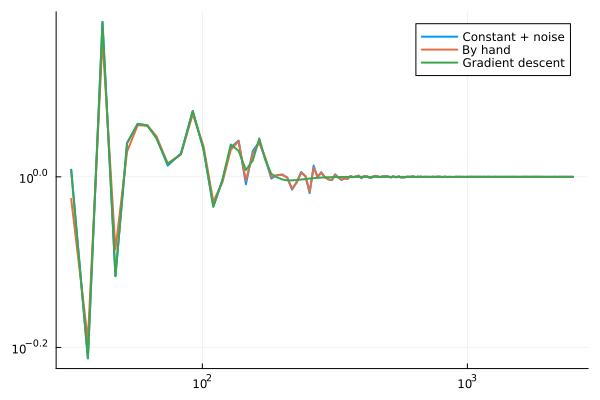

In [68]:
using Plots 

y_pred_manual = by_hand(X_train)[:]
y_pred_gradient = gradient_model(X_train)[:]

plot(X_train[:], y_train, width=2, yscale=:log10, xscale=:log10, label="Constant + noise")
plot!(X_train[:], y_pred_manual, width=2, yscale=:log10, xscale=:log10, label="By hand")
plot!(X_train[:], y_pred_gradient, width=2, yscale=:log10, xscale=:log10, label="Gradient descent")

## On noisy data

Finally, on the noisy data

In [35]:
using LinearAlgebra

# Assume covTT is the full covariance matrix (215, 215), and that X_train has 215 data points

# Ensure that X_train, y_train, and covTT have the correct dimensions
X_train = reshape(lmean, 1, :)
n_R = Cltt_matrix_avg[:,1]

# Verify dimensions
println("Dimensions of X_train: ", size(X_train))
println("Dimensions of n_R: ", size(n_R))

# Do not crop the covariance matrix
inv_covTT = inv(covTT)
println("Dimensions of inv_covTT: ", size(inv_covTT))

@assert size(inv_covTT)[1] == size(n_R)[1]
@assert size(n_R)[1] == size(X_train)[2]

Dimensions of X_train: (1, 215)
Dimensions of n_R: (215,)
Dimensions of inv_covTT: (215, 215)


In [36]:
fake_data = randClTT_matrix[:,7]
y_train = fake_data

215-element Vector{Float64}:
 6.239561206661341
 5.229304410583946
 4.927570228382226
 3.7900720365614817
 3.7985976422641268
 3.210433346053429
 3.27083844147608
 2.7053514098974367
 2.5486110954988423
 1.7893691170959376
 1.8657496125467807
 1.4582958425945354
 1.5376448521360175
 ⋮
 0.0002202289296187437
 0.00018587239202606839
 0.00017516384164126318
 0.0001514270338744396
 0.00015467477527578825
 0.0001373245017247252
 9.481208520265449e-5
 0.0001122233977913386
 0.00011183959471753918
 9.386706287355668e-5
 8.134202317405413e-5
 7.462419400257961e-5

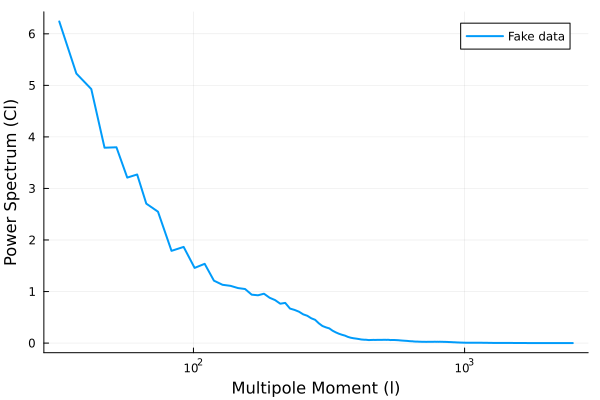

In [37]:

# Plot Cltt_matrix_avg and data on the same scale
plot(lmean, fake_data, label="Fake data", xscale=:log10, lw=2)

# Set labels and title
xlabel!("Multipole Moment (l)")
ylabel!("Power Spectrum (Cl)")


In [38]:
by_hand = Chain(
    Dense(1 => length(y_train), Flux.sigmoid),
    Dense(length(y_train) => 1)
)

Chain(
  Dense(1 => 215, σ),                   # 430 parameters
  Dense(215 => 1),                      # 216 parameters
)                   # Total: 4 arrays, 646 parameters, 2.773 KiB.

In [39]:
dF = similar(y_train)
dF[1] = y_train[1]/n_R[1]
for i in 2:length(y_train)
    dF[i] = y_train[i]/n_R[i] - y_train[i-1]/n_R[i-1]
end

In [40]:
# Compute the weights by hand

theta, re = Flux.destructure(by_hand)

w = 100

for i in 1:length(y_train)
    theta[i] = w
end

for i in (length(y_train) + 1):(2*length(y_train))
    theta[i] = -(w*X_train[i - length(y_train)] - 2.5)
end

for i in (2*length(y_train) + 1):(3*length(y_train))
    theta[i] = dF[i - 2*length(y_train)]
end

by_hand = re(theta)

Chain(
  Dense(1 => 215, σ),                   # 430 parameters
  Dense(215 => 1),                      # 216 parameters
)                   # Total: 4 arrays, 646 parameters, 2.773 KiB.

In [41]:
neg_log_likelihood_ratio(by_hand, X_train, y_train, inv_covTT, n_R)

-96.63063800351517

In [68]:
using Flux

gradient_model = Chain(
    Dense(1 => length(y_train), Flux.sigmoid),
    Dense(length(y_train) => 1)
)

opt = Flux.AdamW(1e-3, (0.99, 0.999))
epochs = 40_000
# for 40_000 epochs
# opt = Flux.Descent() # Gives NaN
# opt = Flux.Momentum() # Gives NaN
# opt = Flux.Nesterov() # Gives NaN
# opt = Flux.AdaDelta() # Huge loss, ruled out at 10_000 epochs
# opt = Flux.RMSProp() # Huge loss, ruled out at 10_000 epochs
# opt = Flux.NAdam() # 5.8
# opt = Flux.ADAM() # -5.56
# opt = Flux.AdaGrad() # -4.60
# opt = Flux.AdamW() # -5.19
# opt = Flux.AMSGrad() # -5.27
opt = Flux.AdaMax() # -5.41

losses = Float64[]

for epoch in 1:epochs
    gs = gradient(() -> neg_log_likelihood_ratio(gradient_model, X_train, y_train, inv_covTT, n_R), Flux.params(gradient_model))
    Flux.Optimise.update!(opt, Flux.params(gradient_model), gs)
    current_loss = neg_log_likelihood_ratio(gradient_model, X_train, y_train, inv_covTT, n_R)
    if epoch%1000 == 0
        push!(losses, current_loss)
        println("Epoch $epoch completed, Loss: ", current_loss)
    end
end


Epoch 1000 completed, Loss: -5.018061082327817
Epoch 2000 completed, Loss: -5.098843454395287
Epoch 3000 completed, Loss: -5.138190513142769
Epoch 4000 completed, Loss: -5.1601914811347545
Epoch 5000 completed, Loss: -5.1898431370838845
Epoch 6000 completed, Loss: -5.221351556254593
Epoch 7000 completed, Loss: -5.244855047176414
Epoch 8000 completed, Loss: -5.263447757722585
Epoch 9000 completed, Loss: -5.26880640627101
Epoch 10000 completed, Loss: -4.677202182353237
Epoch 11000 completed, Loss: -5.277104753777775
Epoch 12000 completed, Loss: -5.280807958485984
Epoch 13000 completed, Loss: -4.57575110437931
Epoch 14000 completed, Loss: -5.288117163193225
Epoch 15000 completed, Loss: -5.009567252027156
Epoch 16000 completed, Loss: -5.294921369541215
Epoch 17000 completed, Loss: -5.298224440910366
Epoch 18000 completed, Loss: -5.299539005735802
Epoch 19000 completed, Loss: -5.3045487301404615
Epoch 20000 completed, Loss: -5.307549576646114
Epoch 21000 completed, Loss: -5.148926811241997


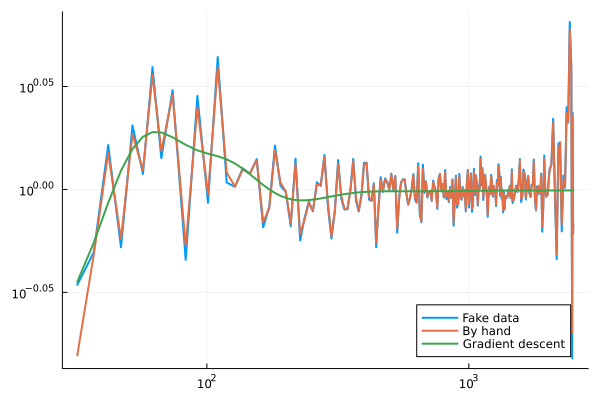

In [69]:
using Plots 

y_pred_manual = by_hand(X_train)[:]
y_pred_gradient = gradient_model(X_train)[:]

plot(X_train[:], y_train./n_R, width=2, yscale=:log10, xscale=:log10, label="Fake data")
plot!(X_train[:], y_pred_manual, width=2, yscale=:log10, xscale=:log10, label="By hand")
plot!(X_train[:], y_pred_gradient, width=2, yscale=:log10, xscale=:log10, label="Gradient descent")

In [ ]:

using LinearAlgebra

# Assume covTT is the full covariance matrix (215, 215), and that X_train has 215 data points

# Ensure that X_train, y_train, and covTT have the correct dimensions
X_train = reshape(lmean, 1, :)
n_R = Cltt_matrix_avg[:,1]

# Verify dimensions
println("Dimensions of X_train: ", size(X_train))
println("Dimensions of n_R: ", size(n_R))

# Do not crop the covariance matrix
inv_covTT = inv(covTT)
println("Dimensions of inv_covTT: ", size(inv_covTT))

@assert size(inv_covTT)[1] == size(n_R)[1]
@assert size(n_R)[1] == size(X_train)[2]

# Loss function without cropping the data
function neg_log_likelihood_ratio(model, X, y, inv_cov_matrix, n_R)
    # Predictions from the trained model
    f_x_w = model(X)[:]
    
    return -n_R' * (2(Diagonal(f_x_w .- 1) * inv_cov_matrix) * y - 
             (Diagonal(f_x_w) * inv_cov_matrix * Diagonal(f_x_w) - inv_cov_matrix)*n_R)/2
end

function dummy_model(X)
    return ones(length(X))
end
@assert neg_log_likelihood_ratio(dummy_model, X_train, n_R, inv_covTT, n_R) == 0

# %% [markdown]
# ## On noisy data

# %% [markdown]
# Finally, on the noisy data

# %%
fake_data = randClTT_matrix[:,7]
y_train = fake_data

# %%
using Flux

grid_to_search = [
    (Flux.AdaGrad(0.5), "Flux.AdaGrad(0.5)"),
    (Flux.AdaGrad(1e-3), "Flux.AdaGrad(1e-3)"),
    (Flux.AdaGrad(1e-5), "Flux.AdaGrad(1e-5)"),
    (Flux.Adam(1e-5, (0.7, 0.9)), "Flux.Adam(1e-5, (0.7, 0.9))"),
    (Flux.Adam(1e-5, (0.7, 0.999)), "Flux.Adam(1e-5, (0.7, 0.999))"),
    (Flux.Adam(1e-5, (0.7, 0.99999)), "Flux.Adam(1e-5, (0.7, 0.99999))"),
    (Flux.Adam(1e-5, (0.9, 0.9)), "Flux.Adam(1e-5, (0.9, 0.9))"),
    (Flux.Adam(1e-5, (0.9, 0.999)), "Flux.Adam(1e-5, (0.9, 0.999))"),
    (Flux.Adam(1e-5, (0.9, 0.99999)), "Flux.Adam(1e-5, (0.9, 0.99999))"),
    (Flux.Adam(1e-5, (0.99, 0.9)), "Flux.Adam(1e-5, (0.99, 0.9))"),
    (Flux.Adam(1e-5, (0.99, 0.999)), "Flux.Adam(1e-5, (0.99, 0.999))"),
    (Flux.Adam(1e-5, (0.99, 0.99999)), "Flux.Adam(1e-5, (0.99, 0.99999))"),
    (Flux.Adam(1e-3, (0.7, 0.9)), "Flux.Adam(1e-3, (0.7, 0.9))"),
    (Flux.Adam(1e-3, (0.7, 0.999)), "Flux.Adam(1e-3, (0.7, 0.999))"),
    (Flux.Adam(1e-3, (0.7, 0.99999)), "Flux.Adam(1e-3, (0.7, 0.99999))"),
    (Flux.Adam(1e-3, (0.9, 0.9)), "Flux.Adam(1e-3, (0.9, 0.9))"),
    (Flux.Adam(1e-3, (0.9, 0.999)), "Flux.Adam(1e-3, (0.9, 0.999))"),
    (Flux.Adam(1e-3, (0.9, 0.99999)), "Flux.Adam(1e-3, (0.9, 0.99999))"),
    (Flux.Adam(1e-3, (0.99, 0.9)), "Flux.Adam(1e-3, (0.99, 0.9))"),
    (Flux.Adam(1e-3, (0.99, 0.999)), "Flux.Adam(1e-3, (0.99, 0.999))"),
    (Flux.Adam(1e-3, (0.99, 0.99999)), "Flux.Adam(1e-3, (0.99, 0.99999))"),
    (Flux.Adam(0.1, (0.7, 0.9)), "Flux.Adam(0.1, (0.7, 0.9))"),
    (Flux.Adam(0.1, (0.7, 0.999)), "Flux.Adam(0.1, (0.7, 0.999))"),
    (Flux.Adam(0.1, (0.7, 0.99999)), "Flux.Adam(0.1, (0.7, 0.99999))"),
    (Flux.Adam(0.1, (0.9, 0.9)), "Flux.Adam(0.1, (0.9, 0.9))"),
    (Flux.Adam(0.1, (0.9, 0.999)), "Flux.Adam(0.1, (0.9, 0.999))"),
    (Flux.Adam(0.1, (0.9, 0.99999)), "Flux.Adam(0.1, (0.9, 0.99999))"),
    (Flux.Adam(0.1, (0.99, 0.9)), "Flux.Adam(0.1, (0.99, 0.9))"),
    (Flux.Adam(0.1, (0.99, 0.999)), "Flux.Adam(0.1, (0.99, 0.999))"),
    (Flux.Adam(0.1, (0.99, 0.99999)), "Flux.Adam(0.1, (0.99, 0.99999))"),
    (Flux.AdamW(1e-5, (0.7, 0.9)), "Flux.AdamW(1e-5, (0.7, 0.9))"),
    (Flux.AdamW(1e-5, (0.7, 0.999)), "Flux.AdamW(1e-5, (0.7, 0.999))"),
    (Flux.AdamW(1e-5, (0.7, 0.99999)), "Flux.AdamW(1e-5, (0.7, 0.99999))"),
    (Flux.AdamW(1e-5, (0.9, 0.9)), "Flux.AdamW(1e-5, (0.9, 0.9))"),
    (Flux.AdamW(1e-5, (0.9, 0.999)), "Flux.AdamW(1e-5, (0.9, 0.999))"),
    (Flux.AdamW(1e-5, (0.9, 0.99999)), "Flux.AdamW(1e-5, (0.9, 0.99999))"),
    (Flux.AdamW(1e-5, (0.99, 0.9)), "Flux.AdamW(1e-5, (0.99, 0.9))"),
    (Flux.AdamW(1e-5, (0.99, 0.999)), "Flux.AdamW(1e-5, (0.99, 0.999))"),
    (Flux.AdamW(1e-5, (0.99, 0.99999)), "Flux.AdamW(1e-5, (0.99, 0.99999))"),
    (Flux.AdamW(1e-3, (0.7, 0.9)), "Flux.AdamW(1e-3, (0.7, 0.9))"),
    (Flux.AdamW(1e-3, (0.7, 0.999)), "Flux.AdamW(1e-3, (0.7, 0.999))"),
    (Flux.AdamW(1e-3, (0.7, 0.99999)), "Flux.AdamW(1e-3, (0.7, 0.99999))"),
    (Flux.AdamW(1e-3, (0.9, 0.9)), "Flux.AdamW(1e-3, (0.9, 0.9))"),
    (Flux.AdamW(1e-3, (0.9, 0.999)), "Flux.AdamW(1e-3, (0.9, 0.999))"),
    (Flux.AdamW(1e-3, (0.9, 0.99999)), "Flux.AdamW(1e-3, (0.9, 0.99999))"),
    (Flux.AdamW(1e-3, (0.99, 0.9)), "Flux.AdamW(1e-3, (0.99, 0.9))"),
    (Flux.AdamW(1e-3, (0.99, 0.999)), "Flux.AdamW(1e-3, (0.99, 0.999))"),
    (Flux.AdamW(1e-3, (0.99, 0.99999)), "Flux.AdamW(1e-3, (0.99, 0.99999))"),
    (Flux.AdamW(0.1, (0.7, 0.9)), "Flux.AdamW(0.1, (0.7, 0.9))"),
    (Flux.AdamW(0.1, (0.7, 0.999)), "Flux.AdamW(0.1, (0.7, 0.999))"),
    (Flux.AdamW(0.1, (0.7, 0.99999)), "Flux.AdamW(0.1, (0.7, 0.99999))"),
    (Flux.AdamW(0.1, (0.9, 0.9)), "Flux.AdamW(0.1, (0.9, 0.9))"),
    (Flux.AdamW(0.1, (0.9, 0.999)), "Flux.AdamW(0.1, (0.9, 0.999))"),
    (Flux.AdamW(0.1, (0.9, 0.99999)), "Flux.AdamW(0.1, (0.9, 0.99999))"),
    (Flux.AdamW(0.1, (0.99, 0.9)), "Flux.AdamW(0.1, (0.99, 0.9))"),
    (Flux.AdamW(0.1, (0.99, 0.999)), "Flux.AdamW(0.1, (0.99, 0.999))"),
    (Flux.AdamW(0.1, (0.99, 0.99999)), "Flux.AdamW(0.1, (0.99, 0.99999))"),
    (Flux.AMSGrad(1e-5, (0.7, 0.9)), "Flux.AMSGrad(1e-5, (0.7, 0.9))"),
    (Flux.AMSGrad(1e-5, (0.7, 0.999)), "Flux.AMSGrad(1e-5, (0.7, 0.999))"),
    (Flux.AMSGrad(1e-5, (0.7, 0.99999)), "Flux.AMSGrad(1e-5, (0.7, 0.99999))"),
    (Flux.AMSGrad(1e-5, (0.9, 0.9)), "Flux.AMSGrad(1e-5, (0.9, 0.9))"),
    (Flux.AMSGrad(1e-5, (0.9, 0.999)), "Flux.AMSGrad(1e-5, (0.9, 0.999))"),
    (Flux.AMSGrad(1e-5, (0.9, 0.99999)), "Flux.AMSGrad(1e-5, (0.9, 0.99999))"),
    (Flux.AMSGrad(1e-5, (0.99, 0.9)), "Flux.AMSGrad(1e-5, (0.99, 0.9))"),
    (Flux.AMSGrad(1e-5, (0.99, 0.999)), "Flux.AMSGrad(1e-5, (0.99, 0.999))"),
    (Flux.AMSGrad(1e-5, (0.99, 0.99999)), "Flux.AMSGrad(1e-5, (0.99, 0.99999))"),
    (Flux.AMSGrad(1e-3, (0.7, 0.9)), "Flux.AMSGrad(1e-3, (0.7, 0.9))"),
    (Flux.AMSGrad(1e-3, (0.7, 0.999)), "Flux.AMSGrad(1e-3, (0.7, 0.999))"),
    (Flux.AMSGrad(1e-3, (0.7, 0.99999)), "Flux.AMSGrad(1e-3, (0.7, 0.99999))"),
    (Flux.AMSGrad(1e-3, (0.9, 0.9)), "Flux.AMSGrad(1e-3, (0.9, 0.9))"),
    (Flux.AMSGrad(1e-3, (0.9, 0.999)), "Flux.AMSGrad(1e-3, (0.9, 0.999))"),
    (Flux.AMSGrad(1e-3, (0.9, 0.99999)), "Flux.AMSGrad(1e-3, (0.9, 0.99999))"),
    (Flux.AMSGrad(1e-3, (0.99, 0.9)), "Flux.AMSGrad(1e-3, (0.99, 0.9))"),
    (Flux.AMSGrad(1e-3, (0.99, 0.999)), "Flux.AMSGrad(1e-3, (0.99, 0.999))"),
    (Flux.AMSGrad(1e-3, (0.99, 0.99999)), "Flux.AMSGrad(1e-3, (0.99, 0.99999))"),
    (Flux.AMSGrad(0.1, (0.7, 0.9)), "Flux.AMSGrad(0.1, (0.7, 0.9))"),
    (Flux.AMSGrad(0.1, (0.7, 0.999)), "Flux.AMSGrad(0.1, (0.7, 0.999))"),
    (Flux.AMSGrad(0.1, (0.7, 0.99999)), "Flux.AMSGrad(0.1, (0.7, 0.99999))"),
    (Flux.AMSGrad(0.1, (0.9, 0.9)), "Flux.AMSGrad(0.1, (0.9, 0.9))"),
    (Flux.AMSGrad(0.1, (0.9, 0.999)), "Flux.AMSGrad(0.1, (0.9, 0.999))"),
    (Flux.AMSGrad(0.1, (0.9, 0.99999)), "Flux.AMSGrad(0.1, (0.9, 0.99999))"),
    (Flux.AMSGrad(0.1, (0.99, 0.9)), "Flux.AMSGrad(0.1, (0.99, 0.9))"),
    (Flux.AMSGrad(0.1, (0.99, 0.999)), "Flux.AMSGrad(0.1, (0.99, 0.999))"),
    (Flux.AMSGrad(0.1, (0.99, 0.99999)), "Flux.AMSGrad(0.1, (0.99, 0.99999))"),
    (Flux.AdaMax(1e-5, (0.7, 0.9)), "Flux.AdaMax(1e-5, (0.7, 0.9))"),
    (Flux.AdaMax(1e-5, (0.7, 0.999)), "Flux.AdaMax(1e-5, (0.7, 0.999))"),
    (Flux.AdaMax(1e-5, (0.7, 0.99999)), "Flux.AdaMax(1e-5, (0.7, 0.99999))"),
    (Flux.AdaMax(1e-5, (0.9, 0.9)), "Flux.AdaMax(1e-5, (0.9, 0.9))"),
    (Flux.AdaMax(1e-5, (0.9, 0.999)), "Flux.AdaMax(1e-5, (0.9, 0.999))"),
    (Flux.AdaMax(1e-5, (0.9, 0.99999)), "Flux.AdaMax(1e-5, (0.9, 0.99999))"),
    (Flux.AdaMax(1e-5, (0.99, 0.9)), "Flux.AdaMax(1e-5, (0.99, 0.9))"),
    (Flux.AdaMax(1e-5, (0.99, 0.999)), "Flux.AdaMax(1e-5, (0.99, 0.999))"),
    (Flux.AdaMax(1e-5, (0.99, 0.99999)), "Flux.AdaMax(1e-5, (0.99, 0.99999))"),
    (Flux.AdaMax(1e-3, (0.7, 0.9)), "Flux.AdaMax(1e-3, (0.7, 0.9))"),
    (Flux.AdaMax(1e-3, (0.7, 0.999)), "Flux.AdaMax(1e-3, (0.7, 0.999))"),
    (Flux.AdaMax(1e-3, (0.7, 0.99999)), "Flux.AdaMax(1e-3, (0.7, 0.99999))"),
    (Flux.AdaMax(1e-3, (0.9, 0.9)), "Flux.AdaMax(1e-3, (0.9, 0.9))"),
    (Flux.AdaMax(1e-3, (0.9, 0.999)), "Flux.AdaMax(1e-3, (0.9, 0.999))"),
    (Flux.AdaMax(1e-3, (0.9, 0.99999)), "Flux.AdaMax(1e-3, (0.9, 0.99999))"),
    (Flux.AdaMax(1e-3, (0.99, 0.9)), "Flux.AdaMax(1e-3, (0.99, 0.9))"),
    (Flux.AdaMax(1e-3, (0.99, 0.999)), "Flux.AdaMax(1e-3, (0.99, 0.999))"),
    (Flux.AdaMax(1e-3, (0.99, 0.99999)), "Flux.AdaMax(1e-3, (0.99, 0.99999))"),
    (Flux.AdaMax(0.1, (0.7, 0.9)), "Flux.AdaMax(0.1, (0.7, 0.9))"),
    (Flux.AdaMax(0.1, (0.7, 0.999)), "Flux.AdaMax(0.1, (0.7, 0.999))"),
    (Flux.AdaMax(0.1, (0.7, 0.99999)), "Flux.AdaMax(0.1, (0.7, 0.99999))"),
    (Flux.AdaMax(0.1, (0.9, 0.9)), "Flux.AdaMax(0.1, (0.9, 0.9))"),
    (Flux.AdaMax(0.1, (0.9, 0.999)), "Flux.AdaMax(0.1, (0.9, 0.999))"),
    (Flux.AdaMax(0.1, (0.9, 0.99999)), "Flux.AdaMax(0.1, (0.9, 0.99999))"),
    (Flux.AdaMax(0.1, (0.99, 0.9)), "Flux.AdaMax(0.1, (0.99, 0.9))"),
    (Flux.AdaMax(0.1, (0.99, 0.999)), "Flux.AdaMax(0.1, (0.99, 0.999))"),
    (Flux.AdaMax(0.1, (0.99, 0.99999)), "Flux.AdaMax(0.1, (0.99, 0.99999)")
]


function train(epochs, opt, opt_name)

    gradient_model = Chain(
        Dense(1 => length(y_train), Flux.sigmoid),
        Dense(length(y_train) => 1)
    )

    best_loss = neg_log_likelihood_ratio(gradient_model, X_train, y_train, inv_covTT, n_R)
    best_model = gradient_model

    for epoch in 1:epochs
        gs = gradient(() -> neg_log_likelihood_ratio(gradient_model, X_train, y_train, inv_covTT, n_R), Flux.params(gradient_model))
        Flux.Optimise.update!(opt, Flux.params(gradient_model), gs)
        current_loss = neg_log_likelihood_ratio(gradient_model, X_train, y_train, inv_covTT, n_R)
        if current_loss < best_loss
            best_loss = current_loss
            best_model = gradient_model
        end
        if epoch%1000 == 0
            println("Optimizer $(opt_name), epoch $(epoch), loss $(current_loss)")
        end
    end

    println(best_loss)
    return best_model, best_loss
end


current_grid = grid_to_search
for epochs in [8_000, 16_000, 32_000, 64_000, 128_000]
    losses = [(train(epochs, opt[1], opt[2])[2], opt) for opt in current_grid]
    sort!(losses, by= x -> x[1])
    global current_grid = [losses[i][2] for i in 1:div(length(current_grid),2)]
    println("Best losses: $([(loss, opt[2]) for (loss, opt) in losses])")
end 

The above grid search gave `Best losses: [(-10.971080342823685, "Flux.AdamW(1e-3, (0.99, 0.999))"), (-10.940177725741814, "Flux.Adam(1e-3, (0.99, 0.999))"), (-10.731637201523132, "Flux.AdaMax(1e-3, (0.99, 0.999))"), (-10.269260727470122, "Flux.AdaMax(1e-3, (0.9, 0.99999))"), (-10.26622695797852, "Flux.Adam(1e-3, (0.9, 0.99999))"), (-9.311406355821898, "Flux.AdaMax(0.1, (0.9, 0.999))")]`

In [ ]:

using LinearAlgebra

# Assume covTT is the full covariance matrix (215, 215), and that X_train has 215 data points

# Ensure that X_train, y_train, and covTT have the correct dimensions
X_train = reshape(lmean, 1, :)
n_R = Cltt_matrix_avg[:,1]

# Verify dimensions
println("Dimensions of X_train: ", size(X_train))
println("Dimensions of n_R: ", size(n_R))

# Do not crop the covariance matrix
inv_covTT = inv(covTT)
println("Dimensions of inv_covTT: ", size(inv_covTT))

@assert size(inv_covTT)[1] == size(n_R)[1]
@assert size(n_R)[1] == size(X_train)[2]

# Loss function without cropping the data
function neg_log_likelihood_ratio(model, X, y, inv_cov_matrix, n_R)
    # Predictions from the trained model
    f_x_w = model(X)[:]
    
    return -n_R' * (2(Diagonal(f_x_w .- 1) * inv_cov_matrix) * y - 
             (Diagonal(f_x_w) * inv_cov_matrix * Diagonal(f_x_w) - inv_cov_matrix)*n_R)/2
end

function dummy_model(X)
    return ones(length(X))
end
@assert neg_log_likelihood_ratio(dummy_model, X_train, n_R, inv_covTT, n_R) == 0

# %% [markdown]
# ## On noisy data

# %% [markdown]
# Finally, on the noisy data

# %%
fake_data = randClTT_matrix[:,7]
y_train = fake_data

# %%
using Flux

grid_to_search = [
    (Flux.AdamW(1e-3, (0.99, 0.999)), "Flux.AdamW(1e-3, (0.99, 0.999))"),
    (Flux.Adam(1e-3, (0.99, 0.999)), "Flux.Adam(1e-3, (0.99, 0.999))"),
    (Flux.AdaMax(1e-3, (0.99, 0.999)), "Flux.AdaMax(1e-3, (0.99, 0.999))"),
    (Flux.AdaMax(1e-3, (0.9, 0.99999)), "Flux.AdaMax(1e-3, (0.9, 0.99999))"),
    (Flux.Adam(1e-3, (0.9, 0.99999)), "Flux.Adam(1e-3, (0.9, 0.99999))"),
    (Flux.AdaMax(0.1, (0.9, 0.999)), "Flux.AdaMax(0.1, (0.9, 0.999))")
]

function train(epochs, opt, opt_name)

    gradient_model = Chain(
        Dense(1 => length(y_train), Flux.sigmoid),
        Dense(length(y_train) => 1)
    )

    best_loss = neg_log_likelihood_ratio(gradient_model, X_train, y_train, inv_covTT, n_R)
    best_model = gradient_model

    for epoch in 1:epochs
        gs = gradient(() -> neg_log_likelihood_ratio(gradient_model, X_train, y_train, inv_covTT, n_R), Flux.params(gradient_model))
        Flux.Optimise.update!(opt, Flux.params(gradient_model), gs)
        current_loss = neg_log_likelihood_ratio(gradient_model, X_train, y_train, inv_covTT, n_R)
        if current_loss < best_loss
            best_loss = current_loss
            best_model = gradient_model
        end
        if epoch%1000 == 0
            println("Optimizer $(opt_name), epoch $(epoch), loss $(current_loss)")
        end
    end

    println(best_loss)
    return best_model, best_loss
end


current_grid = grid_to_search
for epochs in [256_000, 512_000]
    losses = [(train(epochs, opt[1], opt[2])[2], opt) for opt in current_grid]
    sort!(losses, by= x -> x[1])
    global current_grid = [losses[i][2] for i in 1:div(length(current_grid),2)]
    println("Best losses: $([(loss, opt[2]) for (loss, opt) in losses])")
end 